<a href="https://colab.research.google.com/github/omkargolatkar/actin_analysis/blob/main/Actin_Helical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Actin Helical Analysis

In [1]:
#@title change working directory
your_directory = "\"/content/drive/MyDrive/Actin_analysis\"" # @param {type:"string"}

%cd $your_directory

/content/drive/.shortcut-targets-by-id/1ZAWDV03m1MDB61agRZJLx00Fz-zr8uQq/Actin_analysis


## Install and Import modules

In [2]:
%%capture
!pip install python-graphql-client
!pip install rcsbsearchapi

In [3]:
%%capture
!pip install biopython

In [4]:
%%capture
!pip install scikit-spatial==7.0.0
!pip install vg

In [5]:
from rcsbsearchapi.search import TextQuery, AttributeQuery
from rcsbsearchapi import rcsb_attributes as attrs
from rcsbsearchapi.search import SequenceQuery
from python_graphql_client import GraphqlClient
import json
import requests
import os
from collections import Counter
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import data_table
from IPython.display import HTML, display
import time
from sys import version_info
from collections import defaultdict
from Bio import PDB
import warnings
from Bio.PDB import MMCIF2Dict
import gzip
import plotly.graph_objs as go
from shapely.geometry import LineString
from shapely.geometry import Point
# from skspatial.objects import Points
import vg
from plotly.subplots import make_subplots
from scipy.interpolate import CubicSpline
from tqdm import tqdm
import sys

## Search API

In [6]:
#@title Actin structures
python_version = f"{version_info.major}.{version_info.minor}"

sequence_similarity_cutoff = 54 # @param {type:"integer"}
e_value_cutoff = 0.1 # @param {type:"number"}
query_sequence = "MDDDIAALVVDNGSGMCKAGFAGDDAPRAVFPSIVGRPRHQGVMVGMGQKDSYVGDEAQSKRGILTLKYPIEHGIVTNWDDMEKIWHHTFYNELRVAPEEHPVLLTEAPLNPKANREKMTQIMFETFNTPAMYVAIQAVLSLYASGRTTGIVMDSGDGVTHTVPIYEGYALPHAILRLDLAGRDLTDYLMKILTERGYSFTTTAEREIVRDIKEKLCYVALDFEQEMATAASSSSLEKSYELPDGQVITIGNERFRCPEALFQPSFLGMESCGIHETTFNSIMKCDVDIRKDLYANTVLSGGTTMYPGIADRMQKEITALAPSTMKIKIIAPPERKYSVWIGGSILASLSTFQQMWISKQEYDESGPSIVHRKCF" # @param {type:"string"}
# remove whitespaces
query_sequence = "".join(query_sequence.split())
#@markdown - Sequence used : **Human cytoplasmic Actin - P60709**

initial_release_date = "2024-03-01" #@param {type:'date'}

q_seq = SequenceQuery(query_sequence, evalue_cutoff = e_value_cutoff, identity_cutoff = sequence_similarity_cutoff*0.01)

entrypoints = ["polymer_entity","entry","assembly"]

q_date = attrs.rcsb_accession_info.initial_release_date <= initial_release_date

q_final = q_seq & q_date
actin_entity_ids = []
for id in q_final(entrypoints[0]):
   actin_entity_ids.append(id)

actin_pdb_ids = []
for id in q_final(entrypoints[1]):
   actin_pdb_ids.append(id)

actin_assembly_ids = []
for id in q_final(entrypoints[2]):
   actin_assembly_ids.append(id)

entrypoint_dict = {
    'entry':'structures',
    'polymer_entity': 'entities',
    'assembly':'assemblies'}

print("These are the results from the PDB for all the structures with initial release date before {date}".format(date = initial_release_date))
print("actin_entity_ids ({number}): ".format(number=len(actin_entity_ids)), actin_entity_ids)
print("actin_assembly_ids ({number}): ".format(number=len(actin_assembly_ids)), actin_assembly_ids)
print("actin_pdb_ids ({number}): ".format(number=len(actin_pdb_ids)), actin_pdb_ids)

These are the results from the PDB for all the structures with initial release date before 2024-03-01
actin_entity_ids (475):  ['2OAN_1', '3U4L_1', '6ANU_1', '6F1T_2', '6F38_2', '6F3A_2', '6LTJ_7', '6ZNL_2', '6ZNM_2', '6ZNN_2', '6ZNO_2', '6ZO4_3', '7PDZ_3', '7QJ5_2', '7QJ6_1', '7QJ7_2', '7QJ8_3', '7QJ9_2', '7QJA_1', '7QJB_2', '7QJC_1', '7VDV_9', '7Y8R_7', '7Z8F_2', '7Z8M_7', '7ZTC_1', '7ZTD_1', '8IAH_5', '8IAI_4', '8IB2_2', '8IB8_10', '8OI6_1', '8P94_8', '1HLU_1', '2BTF_1', '3BYH_1', '3J0S_1', '3J82_2', '3LUE_1', '3UB5_1', '6NBW_1', '8DNH_1', '6TF9_17', '5NW4_11', '6CXI_1', '6CXJ_1', '6G2T_1', '7NVM_10', '8OID_1', '5JLH_1', '8DNF_1', '8OI8_1', '5ADX_2', '5AFU_6', '7P1H_2', '1D4X_1', '2HF3_1', '2HF4_1', '3EKS_1', '3EKU_1', '3EL2_1', '3MMV_1', '3MN6_1', '3MN7_1', '3MN9_1', '4JHD_1', '4JHD_2', '4RWT_1', '5WFN_1', '6V6S_7', '7AS4_5', '8OH4_1', '4M63_2', '3B63_7', '4CI6_1', '5CE3_1', '4EFH_1', '1NLV_1', '1NM1_1', '1NMD_1', '3CHW_1', '3CI5_1', '3CIP_1', '8J07_67', '3W3D_1', '7JH7_1', '7LRG_1

## Data API

In [7]:
#@title Actin uniprots
ids_lst = json.dumps(actin_entity_ids)
query = '''
{
  polymer_entities(entity_ids: %s) {
    rcsb_id
    rcsb_entity_source_organism {
      ncbi_scientific_name
    }
    entry {
      struct {
        title
      }
    }
    rcsb_polymer_entity {
      pdbx_description
    }
    rcsb_polymer_entity_container_identifiers {
      reference_sequence_identifiers {
        database_accession
        database_name
      }
    }
  }
}

'''
data_query = query % (ids_lst)

url_data_api = "https://data.rcsb.org/graphql"
client = GraphqlClient(endpoint = url_data_api)
result = client.execute(query=data_query)
result = result['data']

print("\033[1m"+"Data API output"+"\033[0;0m")
print('')
json_object = json.dumps(result, indent=4)
#### set 1 (to set sequence similarity cutoff)
#based on the list of entities obtained from search API, fix the sequence similarity cutoff so that the list won't contain any non-actin entities
actin_uniprot_dict = defaultdict(list)
for entity in result['polymer_entities']:
  try:
    for acc in entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers']:
      actin_uniprot_dict[entity['rcsb_id']].append(acc['database_accession'])
  except TypeError:
    actin_uniprot_dict[entity['rcsb_id']].append('none')

actin_uniprot_dict['4PL7_1'] = ['Q9P4D1']
actin_uniprots = [x for xs in list(actin_uniprot_dict.values()) for x in xs if x != 'none']
actin_uniprots = list(set(actin_uniprots))
print("Actin uniprots: ",actin_uniprots)

actin_organism_dict = defaultdict(list)
for entity in result['polymer_entities']:
  try:
    for acc in entity['rcsb_entity_source_organism']:
      actin_organism_dict[entity['rcsb_id']].append(acc['ncbi_scientific_name'])
  except TypeError:
    actin_organism_dict[entity['rcsb_id']].append('none')

actin_names_dict = {}
for entity in result['polymer_entities']:
  try:
    actin_names_dict[entity['rcsb_id']] = entity["rcsb_polymer_entity"]["pdbx_description"]
  except TypeError:
    actin_names_dict[entity['rcsb_id']] = 'none'

actin_str_title_dict = {}
for entity in result['polymer_entities']:
  try:
    actin_str_title_dict[entity['rcsb_id']] = entity["entry"]["struct"]["title"]
  except TypeError:
    actin_str_title_dict[entity['rcsb_id']] = 'none'


#This will print the name and pdb_id of entities which do not have actin in their name or has ('related', 'dynactin') in the name

Data API output

Actin uniprots:  ['P10987', 'P68137', 'G0SE15', 'O93400', 'B6TQ08', 'P63261', 'G3CKA6', 'P68134', 'P68032', 'P45520', 'P68136', 'P02578', 'P60712', 'Q9P4D1', 'P60011', 'Q8ILW9', 'P68135', 'P41340', 'A0A6I9HGD1', 'P60709', 'P63267', 'B6VNT8', 'P0DM41', 'P60010', 'Q4Z1L3', 'Q8I4X0', 'P60706', 'P68139', 'P07830', 'P63270', 'P68033', 'F1RCB6', 'Q4YU79', 'A0A151MAL5', 'P53498', 'Q3ZC07', 'Q6QAQ1']


In [8]:
#@title Actin structures with small molecule data
ids_lst = json.dumps(actin_pdb_ids)
query = '''
{
  entries(entry_ids: %s) {
    rcsb_id
    polymer_entities {
      entity_poly {
        rcsb_entity_polymer_type
        rcsb_sample_sequence_length
      }
      rcsb_polymer_entity {
        pdbx_description
      }
      rcsb_polymer_entity_container_identifiers {
        reference_sequence_identifiers {
          database_accession
          database_name
        }
      }
    }
    nonpolymer_entities {
      nonpolymer_comp {
        chem_comp {
          id
          name
        }
      }
    }
  }
}

'''
data_query = query % (ids_lst)

url_data_api = "https://data.rcsb.org/graphql"
client = GraphqlClient(endpoint = url_data_api)
result = client.execute(query=data_query)
result = result['data']

json_object = json.dumps(result, indent=4)
#### set 1 (to set sequence similarity cutoff)
#based on the list of entities obtained from search API, fix the sequence similarity cutoff so that the list won't contain any non-actin entities
actin_small_mol_dict = defaultdict(list)
for structure in result['entries']:
  try:
    for small_mol in structure['nonpolymer_entities']:
      actin_small_mol_dict[structure['rcsb_id']].append(small_mol['nonpolymer_comp']['chem_comp']['id'])
  except TypeError:
    actin_small_mol_dict[structure['rcsb_id']].append('none')

actin_all_entities_dict = defaultdict(list)
actin_all_entities_dict_len = defaultdict(list)
for structure in result['entries']:
  try:
    for entity in structure['polymer_entities']:
      actin_all_entities_dict[structure['rcsb_id']].append(entity['rcsb_polymer_entity']['pdbx_description'])
      actin_all_entities_dict_len[structure['rcsb_id']].append((entity['rcsb_polymer_entity']['pdbx_description'],entity['entity_poly']['rcsb_sample_sequence_length']))
  except TypeError:
    actin_all_entities_dict[structure['rcsb_id']].append('none')
    actin_all_entities_dict_len[structure['rcsb_id']].append('none')

In [9]:
#@title Actin small molecule subdicts all
import itertools

smol_dict = {}
pol_dict = defaultdict(list)

for k, v in actin_small_mol_dict.items():
  ntp_lst = []
  stab_lst = []
  for small_mol in v:
    # if small_mol in small_mol_lst:
    ntp_lst.append(small_mol)
  smol_dict[k] = ntp_lst

non_red_small_mol_lst = list(set(list(itertools.chain(*list(smol_dict.values())))))

for k, v in actin_all_entities_dict_len.items():
  for ent in v:
    if ent[1] <= 20:
      pol_dict[k].append(ent[0])

In [10]:
for k, v in actin_small_mol_dict.items():
  if non_red_small_mol_lst[0] in v:
    print(k, v)

6WK2 ['SAM', 'NA', 'EDO']


In [11]:
#@title Actin small molecule subdicts

NTP_dict = {}
stab_dict = {}
small_mol_lst = ['ATP',
                 'ADP',
                 'ANP',
                 'LAB',
                 'CY9',
                 'KAB',
                 'JQV',
                 'PO4'
                 ]

ion_lst = ['MG',
           'CA']


for k, v in actin_small_mol_dict.items():
  ntp_lst = []
  stab_lst = []
  for small_mol in v:
    if small_mol in small_mol_lst:
      ntp_lst.append(small_mol)
    elif small_mol == '9ZK' or small_mol == 'RLZ' or small_mol == '9UE':
      stab_lst.append('jasplakinolide')
    elif small_mol == '1T4':
      stab_lst.append('pyrene')
    elif small_mol == 'APR':
      stab_lst.append('APR')


  NTP_dict[k] = ntp_lst
  stab_dict[k] = stab_lst

for k, v in actin_all_entities_dict.items():
  for entity_name in v:
    if "phalloidin" in entity_name.lower():
      stab_dict[k].append('phalloidin')
    elif "lifeact" in entity_name.lower():
      stab_dict[k].append('lifeact')

NTP_dict["7PME"] = ['ADP']
NTP_dict["6W17"] = ['ADP']
NTP_dict["8E9B"] = ['ADP']
NTP_dict["8UXW"] = ['ADP']
NTP_dict["8UXX"] = ['ADP']

In [12]:
#@title generate dataset
ids_lst = json.dumps(actin_assembly_ids)
query = '''
{
  assemblies(assembly_ids: %s) {
    rcsb_id
    entry {
      exptl {
        method
      }
      rcsb_entry_container_identifiers {
        entry_id
      }
      rcsb_entry_info {
        resolution_combined
      }
      struct {
        title
      }
      assemblies {
        rcsb_struct_symmetry {
          type
          rotation_axes {
            start
            end
            order
          }
          kind
          clusters {
            members {
              asym_id
              pdbx_struct_oper_list_ids
            }
          }
        }
      }
      polymer_entities {
        polymer_entity_instances {
          rcsb_polymer_entity_instance_container_identifiers {
            asym_id
            auth_asym_id
          }
        }
        rcsb_polymer_entity {
          pdbx_description
        }
        rcsb_polymer_entity_container_identifiers {
          reference_sequence_identifiers {
            database_accession
            database_name
          }
        }
      }
    }
  }
}
'''
data_query = query % (ids_lst)

url_data_api = "https://data.rcsb.org/graphql" #param {type:"string"}
client = GraphqlClient(endpoint = url_data_api)
result = client.execute(query=data_query)
result = result['data']



json_object = json.dumps(result, indent=4)
#### set 1 (to set sequence similarity cutoff)
#based on the list of entities obtained from search API, fix the sequence similarity cutoff so that the list won't contain any non-actin entities

#This will print the name and pdb_id of entities which do not have actin in their name or has ('related', 'dynactin') in the name

## Post processing

In [13]:
#@title JSON to Dataframe
#markdown - For better visualization, convert the json object obtained from data API to a dataframe
#markdown - Each row of the dataframe corresponds to

master_lst = []
error_lst = []
for assembly in result['assemblies']:
  assembly_id = assembly['rcsb_id']
  try:
    exptl_methods = []
    for method in assembly['entry']['exptl']:
      exptl_methods.append(method['method'])
    exptl_method = ','.join(exptl_methods)
    pdb_resolution = assembly['entry']['rcsb_entry_info']['resolution_combined'][0]

    pdb_chain_map = {}
    for entity in assembly['entry']['polymer_entities']:
      for ch in entity['polymer_entity_instances']:
        auth_ch_id = ch['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id']
        pdb_ch_id = ch['rcsb_polymer_entity_instance_container_identifiers']['asym_id']
        pdb_chain_map[pdb_ch_id] = auth_ch_id

    for symmetry in assembly['entry']['assemblies']:
      for cluster in symmetry['rcsb_struct_symmetry']:
        sym_type = cluster['type']
        sym_kind = cluster['kind']
        cluster_chains = []
        for groups in cluster['clusters']:
          group = []
          for chain in groups['members']:
            group.append(pdb_chain_map[chain['asym_id']])
          cluster_chains.append(group)
        for axes in cluster['rotation_axes']:
          rotation_start = axes['start']
          rotation_end = axes['end']
        master_lst.append([assembly_id,exptl_method,pdb_resolution,sym_type,sym_kind,cluster_chains,rotation_start,rotation_end])
  except TypeError:
    error_lst.append(assembly_id)
    try:
      exptl_methods = []
      for method in assembly['entry']['exptl']:
        exptl_methods.append(method['method'])
      exptl_method = ','.join(exptl_methods)
    except TypeError:
      exptl_method = 'none'
    try:
      pdb_resolution = assembly['entry']['rcsb_entry_info']['resolution_combined'][0]
    except TypeError:
      pdb_resolution = 'none'
    try:
      pdb_chain_map = {}
      for entity in assembly['entry']['polymer_entities']:
        for ch in entity['polymer_entity_instances']:
          auth_ch_id = ch['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id']
          pdb_ch_id = ch['rcsb_polymer_entity_instance_container_identifiers']['asym_id']
          pdb_chain_map[pdb_ch_id] = auth_ch_id
      for symmetry in assembly['entry']['assemblies']:
        for cluster in symmetry['rcsb_struct_symmetry']:
          sym_type = cluster['type']
          sym_kind = cluster['kind']
          cluster_chains = []
          for groups in cluster['clusters']:
            group = []
            for chain in groups['members']:
              group.append(pdb_chain_map[chain['asym_id']])
            cluster_chains.append(group)
          try:
            for axes in cluster['rotation_axes']:
              rotation_start = axes['start']
              rotation_end = axes['end']
          except TypeError:
            rotation_start = 'none'
            rotation_end = 'none'
          master_lst.append([assembly_id,exptl_method,pdb_resolution,sym_type,sym_kind,cluster_chains,rotation_start,rotation_end])
    except TypeError:
      sym_type = 'none'
      sym_kind = 'none'
      cluster_chains = 'none'
      rotation_start = 'none'
      rotation_end = 'none'
      master_lst.append([assembly_id,exptl_method,pdb_resolution,sym_type,sym_kind,cluster_chains,rotation_start,rotation_end])
    pass

df = pd.DataFrame(master_lst,columns=['assembly_id','method','resolution','sym_type','sym_kind','cluster_chains','rotation_axis_start','rotation_axis_end'])
df.index+=1

print("Entities which have some missing field: ", error_lst,"\n")

df_actin_fil = df[df['sym_type'] == "Helical"]
df_actin_fil = df_actin_fil[df_actin_fil['sym_kind'] != 'Pseudo Symmetry']
# data_table.DataTable(df_actin_fil)

#the df_act_fil contains helical assemblies with global or local symmetry types
#cluster_chains in the df_act_fil are according to author chain ids

Entities which have some missing field:  ['3U4L-1', '6F1T-1', '6F38-1', '6F3A-1', '6LTJ-1', '6ZNL-1', '6ZNM-1', '6ZNN-1', '6ZNO-1', '6ZO4-1', '7PDZ-1', '7QJ5-1', '7QJ6-1', '7QJ7-1', '7QJ8-1', '7QJ9-1', '7QJA-1', '7QJB-1', '7QJC-1', '7VDV-1', '7Y8R-1', '7Z8F-1', '7Z8M-1', '8IAH-1', '8IAI-1', '8IB2-1', '8IB8-1', '8OI6-1', '8P94-1', '1HLU-1', '2BTF-1', '3J82-1', '3UB5-1', '6NBW-1', '6TF9-1', '5NW4-1', '6CXI-1', '6CXJ-1', '7NVM-1', '5JLH-1', '5ADX-1', '5AFU-1', '7P1H-1', '1D4X-1', '1D4X-2', '2HF3-1', '2HF4-1', '3EKS-1', '3EKU-1', '3EL2-1', '3MMV-1', '3MN6-1', '3MN6-2', '3MN6-3', '3MN7-1', '3MN9-1', '4JHD-1', '4JHD-2', '4RWT-1', '4RWT-2', '5WFN-1', '5WFN-2', '6V6S-1', '7AS4-1', '4M63-1', '3B63-1', '4CI6-1', '5CE3-1', '5CE3-2', '4EFH-1', '1NLV-1', '1NLV-2', '1NM1-1', '1NM1-2', '1NMD-1', '1NMD-2', '3CHW-1', '3CI5-1', '3CI5-2', '3CIP-1', '3CIP-2', '8J07-1', '3W3D-1', '7JH7-1', '8DD0-1', '8EFH-1', '8EFI-1', '8ENC-1', '8GSU-1', '1EQY-1', '1ESV-1', '1H1V-1', '1IJJ-1', '1IJJ-2', '1J6Z-1', '1KXP-1'

In [14]:
#@title which chains are actin chains in each assembly
master_lst = []
master_lst2 = []
error_lst = []
for assembly in result['assemblies']:
  assembly_id = assembly['rcsb_id']
  for entity in assembly['entry']['polymer_entities']:
    actin_entity_uniprots = []
    actin_entity_chains = []
    actin_entity_name = entity['rcsb_polymer_entity']['pdbx_description']
    try:
      for acc in entity['rcsb_polymer_entity_container_identifiers']['reference_sequence_identifiers']:
        if acc['database_accession'] in actin_uniprots:
          actin_entity_uniprots.append(acc['database_accession'])
          for pdb_chain in entity['polymer_entity_instances']:
            actin_entity_chains.append(pdb_chain['rcsb_polymer_entity_instance_container_identifiers']['auth_asym_id'])
      master_lst.append([assembly_id,actin_entity_chains])
      master_lst2.append([actin_entity_uniprots, actin_entity_name])
    except:
      error_lst.append(assembly_id)
      master_lst.append([assembly_id,actin_entity_chains])
      master_lst2.append([actin_entity_uniprots, actin_entity_name])
    pass

df_actin_chains = pd.DataFrame(master_lst,columns=['assembly_id','actin_chains'])
df_actin_chains.index+=1
data_table.DataTable(df_actin_chains)

act_chains_in_assembly_dict = defaultdict(list) #dictionary with key = assembly_id and value = list of actin chains
for index, row in df_actin_chains.iterrows():
  if row['actin_chains'] != []:
    for elem in row['actin_chains']:
      act_chains_in_assembly_dict[row['assembly_id']].append(elem)

df_actin_uniprot_names = pd.DataFrame(master_lst2, columns=['uniprot_id','name'])
df_actin_uniprot_names.index+=1
data_table.DataTable(df_actin_uniprot_names)

actin_uniprot_names_dict = defaultdict(list)
for index, row in df_actin_uniprot_names.iterrows():
  if row['uniprot_id'] != []:
    for elem in row['uniprot_id']:
      actin_uniprot_names_dict[elem].append(row['name'])

for key, value in actin_uniprot_names_dict.items():
  mod_val = list(set(value))
  actin_uniprot_names_dict[key] = mod_val # check whether all the uniprots in actin uniprots are of actin only

# P62328 is not actin 4PL7 chimeric actin
# actin_uniprots.remove('P62328') # actin uniprots from the whole dataset

In [15]:
#@title resolution dict
pdb_res_dict = {}
for assembly in result['assemblies']:
  assembly_id = assembly['rcsb_id']
  try:
    exptl_methods = []
    for method in assembly['entry']['exptl']:
      exptl_methods.append(method['method'])
    exptl_method = ','.join(exptl_methods)
    pdb_resolution = assembly['entry']['rcsb_entry_info']['resolution_combined'][0]
  except TypeError:
    pdb_resolution = 10000

  pdb_res_dict[assembly_id] = pdb_resolution

In [16]:
#@title classify actin filaments
# if num of actin chains in helical cluster is more than or equal to 3 then its a filament (except - 3TPQ, 2YJF - form helical clusters but are not filaments)
actin_fil_dict_lst = []
for index, row in df_actin_fil.iterrows():
  if row['assembly_id'] in list(act_chains_in_assembly_dict.keys()):
    actin_chains = act_chains_in_assembly_dict[row['assembly_id']]
    cluster_chains = row['cluster_chains']
    for cluster in cluster_chains:
      counter = 0
      for elem in cluster:
        if elem in actin_chains:
          counter+=1
      # common_act_chains = list(set(cluster).intersection(actin_chains))
      # uncom_chains = list(set(actin_chains)^set(common_act_chains))
      # if len(actin_chains) >= 3:
      if counter > 2:
        actin_fil_dict_lst.append(row.to_dict())

actin_filaments_df = pd.DataFrame.from_records(actin_fil_dict_lst)

filament_assemblies = list(set(list(actin_filaments_df['assembly_id']))) # manually check for actin filaments
filament_pdbs = list(set([x[0:4] for x in filament_assemblies]))

actin_filaments_df = actin_filaments_df[actin_filaments_df['assembly_id'].str.startswith("3TPQ") == False]
actin_filaments_df = actin_filaments_df[actin_filaments_df['assembly_id'].str.startswith("2YJF") == False]
actin_filaments_df = actin_filaments_df[actin_filaments_df['assembly_id'].str.startswith("4M63") == False]
actin_filaments_df = actin_filaments_df[actin_filaments_df['sym_kind'] != 'Pseudo Symmetry']

filament_assemblies = list(set(list(actin_filaments_df['assembly_id']))) #187 actin filaments (assemblies)
filament_pdbs = list(set([x[0:4] for x in filament_assemblies])) #187 actin filament (PDBs)

actin_filaments_df_globalsym = actin_filaments_df[actin_filaments_df['sym_kind'] == 'Global Symmetry']
actin_filaments_df_localsym = actin_filaments_df[actin_filaments_df['sym_kind'] == 'Local Symmetry']
# data_table.DataTable(actin_filaments_df)

In [17]:
from itertools import chain
non_red_filament_small_mol_lst = []
for k, v in actin_small_mol_dict.items():
  if k in filament_pdbs:
    for smol in v:
      if smol not in non_red_filament_small_mol_lst:
        non_red_filament_small_mol_lst.append(smol)

filament_smol_dict = {}
for k, v in actin_small_mol_dict.items():
  if k in filament_pdbs:
    filament_smol_dict[k] = v

filament_smol_dict["7PME"] = ['ADP', 'MG']
filament_smol_dict["6W17"] = ['ADP', 'MG']
filament_smol_dict["8E9B"] = ['ADP', 'MG']
filament_smol_dict["8UXW"] = ['ADP', 'MG']
filament_smol_dict["8UXX"] = ['ADP', 'MG']
filament_smol_dict["7Z7H"] = ['ADP', 'MG', 'APR']
filament_smol_dict["7P1G"] = ['ADP','MG','PO4']

non_red_filament_small_mol_lst = list(set(chain.from_iterable(list(filament_smol_dict.values()))))
non_red_filament_stab_lst = list(set(chain.from_iterable(list(stab_dict.values()))))

adp_po4 = []
for k, v in filament_smol_dict.items():
  if 'ADP' in v and 'PO4' in v:
    adp_po4.append(k)

only_adp = []
for k, v in filament_smol_dict.items():
  if 'ADP' in v and 'PO4' not in v:
    only_adp.append(k)

In [18]:
actin_res_pdbs = []
for k, v in pdb_res_dict.items():
  if v <= 4 and k[0:4] in filament_pdbs:
    actin_res_pdbs.append(k[0:4])

smol_dict_pdbs_fil = {}
for elem in non_red_filament_small_mol_lst :
  smol_dict_pdbs_fil[elem] = []

for k, v in filament_smol_dict.items():
  for smol in v:
    if k not in smol_dict_pdbs_fil[smol]:
      smol_dict_pdbs_fil[smol].append(k)

for elem in non_red_filament_stab_lst :
  if elem in ["phalloidin","lifeact"]:
    smol_dict_pdbs_fil[elem] = []

for k, v in stab_dict.items():
  for smol in v:
    if smol in ['phalloidin','lifeact']:
      if k not in smol_dict_pdbs_fil[smol]:
        smol_dict_pdbs_fil[smol].append(k)

smol_dict_pdbs_fil_res = {}
for k, v in smol_dict_pdbs_fil.items():
  new_v = [psd for psd in v if psd in actin_res_pdbs]
  smol_dict_pdbs_fil_res[k] = new_v

<ipython-input-20-7984fe1cb075>:61: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha = 'center')


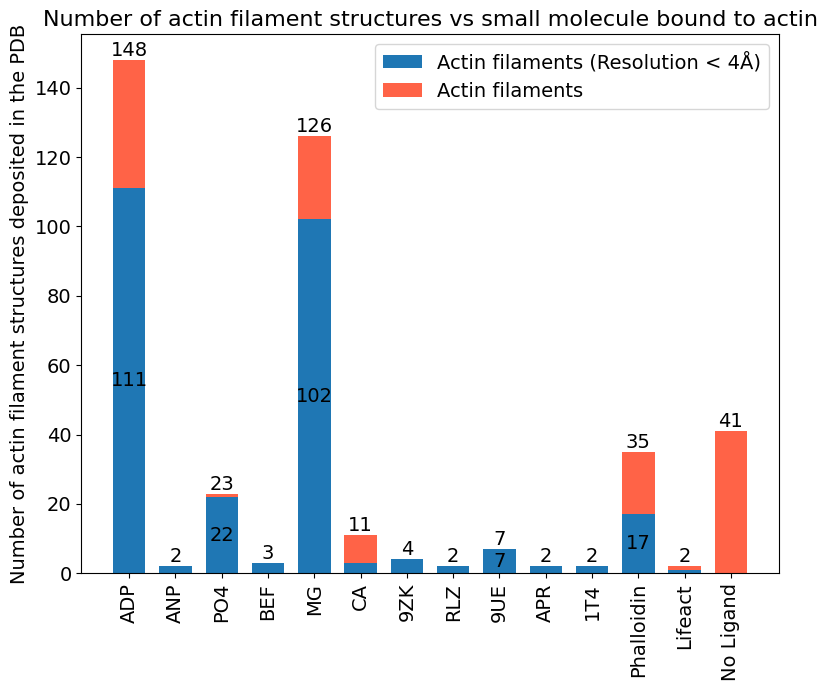

In [20]:
plot_dict = {}

# plot_dict = dict(sorted(plot_dict.items(), key=lambda item: item[1], reverse = True))

for smol in ['ADP','ANP','PO4','BEF','MG','CA','9ZK','RLZ','9UE']:
  plot_dict[smol] = len(smol_dict_pdbs_fil[smol])

# for smol in ['9ZK','RLZ','9UE']:
#   plot_dict[smol] = len(smol_dict_pdbs_fil[smol])

# for smol in ['MG','CA','BEF']:
#   plot_dict[smol] = len(smol_dict_pdbs_fil[smol])
for smol in non_red_filament_small_mol_lst:
  if smol not in ['9ZK','RLZ','9UE','none','MG','CA','BEF','ADP','ANP']:
    plot_dict[smol] = len(smol_dict_pdbs_fil[smol])

plot_dict['Phalloidin'] = len(smol_dict_pdbs_fil['phalloidin'])
plot_dict['Lifeact'] = len(smol_dict_pdbs_fil['lifeact'])
plot_dict['No Ligand'] = len(smol_dict_pdbs_fil['none'])

plot_dict2 = {}

# plot_dict = dict(sorted(plot_dict.items(), key=lambda item: item[1], reverse = True))

for smol in ['ADP','ANP','PO4','BEF','MG','CA','9ZK','RLZ','9UE']:
  plot_dict2[smol] = len(smol_dict_pdbs_fil_res[smol])

# for smol in ['9ZK','RLZ','9UE']:
#   plot_dict[smol] = len(smol_dict_pdbs_fil[smol])

# for smol in ['MG','CA','BEF']:
#   plot_dict[smol] = len(smol_dict_pdbs_fil[smol])
for smol in non_red_filament_small_mol_lst:
  if smol not in ['9ZK','RLZ','9UE','none','MG','CA','BEF','ADP','ANP']:
    plot_dict2[smol] = len(smol_dict_pdbs_fil_res[smol])

plot_dict2['Phalloidin'] = len(smol_dict_pdbs_fil_res['phalloidin'])
plot_dict2['Lifeact'] = len(smol_dict_pdbs_fil_res['lifeact'])
plot_dict2['No Ligand'] = len(smol_dict_pdbs_fil_res['none'])

for elem in list(set(list(plot_dict.keys()))):
  plot_dict[elem] = plot_dict[elem] - plot_dict2[elem]

x = list(plot_dict.keys())
y1 = list(plot_dict.values())
y2 = list(plot_dict2.values())

fig, ax = plt.subplots()

bars2 = ax.bar(x,y2, width = 0.7, label = 'Actin filaments (Resolution < 4Å)')
# ax.bar_label(bars2)

for c in ax.containers:
    # Filter the labels
    labels = [v if v > 5 else "" for v in c.datavalues]
    ax.bar_label(c, labels=labels, label_type="center")

bars = ax.bar(x,y1,bottom = y2,color = 'tomato',width= 0.7, label = 'Actin filaments')
ax.bar_label(bars)

ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha = 'center')
# xtickslocs = ax.get_xticks()

# labels = [item.get_text() for item in ax.get_xticklabels()]
# labels=ax.get_xticks()
# labels[11] = 'No ligand'
# ax.xaxis.set_ticks(xtickslocs)
# ax.set_xticklabels(labels)
ax.legend()
# plt.xlabel('Small molecule')
plt.ylabel('Number of actin filament structures deposited in the PDB')
plt.title('Number of actin filament structures vs small molecule bound to actin')

fig.set_size_inches(9, 7)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)

plt.savefig('structures_vs_small_molecule.png', dpi = 300,bbox_inches='tight')
plt.show()

In [21]:
#@title keep only actin chains in cluster_chains

master_lst3 = []
actin_filaments_with_act_clust_dict = defaultdict(list)
for index, row in actin_filaments_df.iterrows():
  rowdict = row.to_dict()
  flat_clus_chains = [elem for cluster in rowdict['cluster_chains'] for elem in cluster ]
  assembly_id = rowdict['assembly_id']
  actin_chains_in_assembly = act_chains_in_assembly_dict[assembly_id]
  act_chains_in_clus = [i for i in actin_chains_in_assembly if i in flat_clus_chains]
  act_chains_not_in_clus = list(set(act_chains_in_clus)^set(actin_chains_in_assembly))
  non_act_in_clus = list(set(act_chains_in_clus)^set(flat_clus_chains))
  rowdict['act_cluster_chains'] = act_chains_in_clus
  rowdict['act_not_in_cluster_chains'] = act_chains_not_in_clus
  rowdict['non_act_in_cluster_chains'] = non_act_in_clus
  master_lst3.append(rowdict)
  actin_filaments_with_act_clust_dict[rowdict['assembly_id']].append(rowdict)
actin_filaments_df_with_act_clust = pd.DataFrame.from_records(master_lst3)
# data_table.DataTable(actin_filaments_df_with_act_clust)

In [22]:
sorted(actin_filaments_with_act_clust_dict['8UXX-1'][0]['act_cluster_chains'])

['P', 'Q', 'R']

In [23]:
#@title modify act_chains_in_assembly_dict
filepath = "./actin_dataset/act_modified_assemblies.csv"

mod_assem_df = pd.read_csv(filepath)

mod_assem_df = mod_assem_df.iloc[:,1:]
mod_assem_df.index+=1

for index, row in mod_assem_df.iterrows():
  pdb_id = row['PDB_id']
  mod_act_chains = row['new_act_chains'].split(',')
  for key, value in act_chains_in_assembly_dict.items():
    if pdb_id in key:
      act_chains_in_assembly_dict[key] = mod_act_chains

## Plots

non-filament actin structures:  {'3': 186, '3.5': 228, '4': 244, '4.5': 251, '5': 253, '5.5': 254, '6': 254, 'No cutoff': 276}
filament actin structures:  {'3': 31, '3.5': 69, '4': 113, '4.5': 119, '5': 125, '5.5': 128, '6': 130, 'No cutoff': 192}


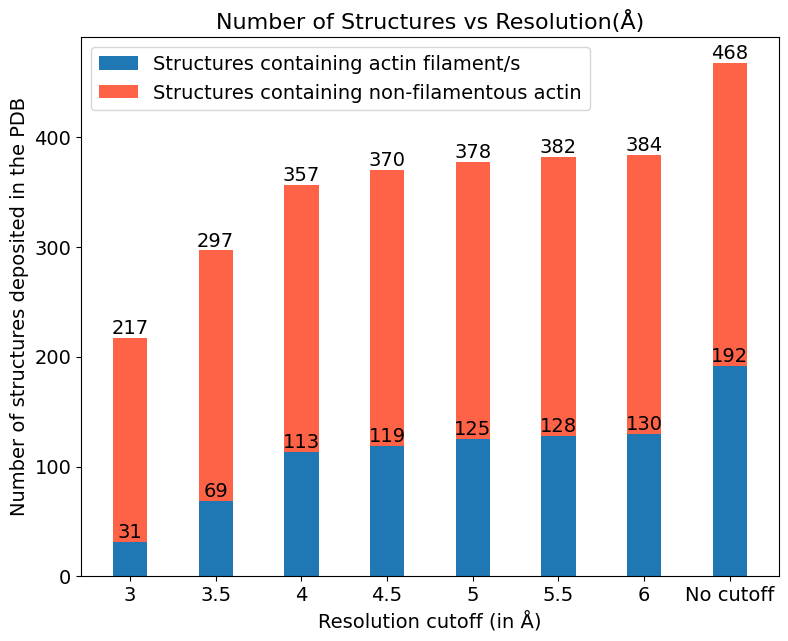

In [25]:
#@title Resolution wise actin structures

#df = df[df['resolution'] != 'none']
actin_assemblies = list(set(list(df['assembly_id'])))
all_actin_pdbs = list(set([x[0:4] for x in actin_assemblies]))

plot_dict = {}
plot_dict2 = {}
master_lst =[]
master_lst2 = []
res_cutoff = [3,3.5,4,4.5,5,5.5,6]
no_res_list_all = []
no_res_list_f = []

for ress in res_cutoff:
	loop_lst = []
	for index,row in df.iterrows():
		res = row['resolution']
		#res = res[:-1]
		try:
			if float(res) <= ress:
				loop_lst.append(row['assembly_id'][0:4])
		except ValueError:
			no_res_list_all.append(row['assembly_id'][0:4])
			pass
	loop_lst = list(set(loop_lst))
	master_lst.append(len(loop_lst))
	loop_lst2 = []

	for index,row in actin_filaments_df.iterrows():
		res = row['resolution']#[1:]
		#res = res[:-1]
		try:
			if float(res) <= ress:
				loop_lst2.append(row['assembly_id'][0:4])
		except ValueError:
			no_res_list_f.append(row['assembly_id'][0:4])
			pass
	loop_lst2 = list(set(loop_lst2))
	master_lst2.append(len(loop_lst2))
#print(master_lst,master_lst2)

no_res_list_all = list(set(no_res_list_all))
no_res_list_f = list(set(no_res_list_f))

for i in range(0,len(res_cutoff)):
  plot_dict[str(res_cutoff[i])] = master_lst[i] - master_lst2[i]

plot_dict['No cutoff'] = len(all_actin_pdbs) - len(filament_pdbs)

for i in range(0,len(res_cutoff)):
  plot_dict2[str(res_cutoff[i])] = master_lst2[i]

plot_dict2['No cutoff'] = len(filament_pdbs)

print("non-filament actin structures: ", plot_dict)
print("filament actin structures: ", plot_dict2)

x = list(plot_dict.keys())
y1 = list(plot_dict.values())
y2 = list(plot_dict2.values())

fig, ax = plt.subplots()

bars2 = ax.bar(x,y2, width = 0.4, label = 'Structures containing actin filament/s')
ax.bar_label(bars2)
bars = ax.bar(x,y1,bottom = y2,color = 'tomato',width= 0.4, label = 'Structures containing non-filamentous actin')
ax.bar_label(bars)
ax.legend()
plt.xlabel('Resolution cutoff (in Å)')
plt.ylabel('Number of structures deposited in the PDB')
plt.title('Number of Structures vs Resolution(Å)')

fig.set_size_inches(9, 7)
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)

# plt.savefig('structures_vs_resolution_plot.png', dpi = 300)
plt.show()

## Download actin filament PDBs

In [26]:
#@title download actin filament PDBs
def get_pdb_download_link(assembly_id):
	link_pattern = 'https://files.rcsb.org/download/{}.cif.gz'#pdb or cif
	return link_pattern.format(assembly_id)

import os
import urllib
import requests
from time import sleep

# save_path = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/actin_filaments_cifs"
save_path = "./actin_dataset/actin_filaments_cifs"

os.makedirs(save_path, exist_ok=True)

for ID in filament_assemblies:
  filename = ID[0:5] + "assembly"+ ID.partition('-')[2]
  completeName = os.path.join(save_path,filename+'.cif.gz') #cif or pdb
  if os.path.exists(completeName) == False:
    pdb_url = get_pdb_download_link(filename)
    r = requests.get(pdb_url)
    #pdb_filename = os.path.basename(r.url)
    f = open(completeName, 'wb')
    f.write(r.content)
    f.close()
    sleep(0.5)

# check whether no of files mathces with number in filament assemblies

## Detect more than 2 fils in 1 structure

In [ ]:
#@title downlaod pdb images
def get_img_download_link(assembly_id):
	link_pattern = 'https://cdn.rcsb.org/images/structures/{}.jpeg'#pdb or cif
	return link_pattern.format(assembly_id)

# https://cdn.rcsb.org/images/structures/2ax6_assembly-1.jpeg
import os
import urllib
import requests
from time import sleep

# save_path = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/actin_helicity_analysis/actin_filaments_images"
save_path = "./actin_dataset/actin_filaments_images"

os.makedirs(save_path, exist_ok=True)

for ID in filament_assemblies:
  filename = ID[0:4].lower()+"_" + "assembly-"+ ID.partition('-')[2]
  completeName = os.path.join(save_path,filename+'.jpeg') #cif or pdb
  if os.path.exists(completeName) == False:
    img_url = get_img_download_link(filename)
    r = requests.get(img_url)
    #pdb_filename = os.path.basename(r.url)
    f = open(completeName, 'wb')
    f.write(r.content)
    f.close()
    sleep(0.5)


## Functions

In [27]:
#@title functions

centroids_to_consider = 0 # @param ["2", "0", "10"] {type:"raw"}
def Sort(sub_li):
  return(sorted(sub_li, key = lambda x: x[2]))

def Sort_ref(sub_li, ref_pt):
  ref_pt = np.array(ref_pt)
  dist_dict = {}
  sort_li = []
  for poit in sub_li:
    poit_dist = np.linalg.norm(ref_pt - poit)
    dist_dict[poit_dist] = poit
  dist_sort = sorted(list(dist_dict.keys()))
  for dis in dist_sort:
    sort_li.append(dist_dict[dis])
  sort_li = np.array(sort_li)
  return sort_li

def define_axis_spline_curve(x,y,z,res=0.05):
	cs_x = CubicSpline(np.arange(0,len(x)), x, bc_type='natural')
	x_spline = cs_x(np.arange(-1, len(x), res))
	cs_y = CubicSpline(np.arange(0,len(y)), y, bc_type='natural')
	y_spline = cs_y(np.arange(-1, len(y), res))
	cs_z = CubicSpline(np.arange(0,len(z)), z, bc_type='natural')
	z_spline = cs_z(np.arange(-1, len(z), res))
	central_axis = np.stack((x_spline, y_spline, z_spline),axis=-1)
	return central_axis

def get_coord_of_min_dist(pt, axis):
	pt_repeat = np.repeat(np.expand_dims(pt, axis=0), len(axis), axis=0)
	dists = np.linalg.norm(pt_repeat - axis, axis=1)
	min_dist_arg = np.argmin(dists)
	vect_to_center = axis[min_dist_arg] - pt
	vect_to_center = vect_to_center / np.linalg.norm(vect_to_center) * 15.76719916835962
	return vect_to_center


# # Define the objective function to minimize
# def objective_function(params, centroids_array, sym_axis_new):
#     # Extract rotation and translation parameters
#     translation_ax = params[:].reshape((2, 3))


#     # Apply rotation and translation to the original axis
#     # rotated_axis = np.dot(sym_axis_new - sym_axis_new[0], rotation_matrix.T) + translation_vector
#     rotated_axis = np.array([sym_axis_new[0] + translation_ax[0],sym_axis_new[1] + translation_ax[1]])

#     # Transform centroids using the new axis
#     transformed = []
#     for ps in centroids_array:
#         pt = Point(ps[0], ps[1], ps[2])
#         lne = LineString([rotated_axis[0], rotated_axis[1]])
#         x = np.array(pt.coords[0])
#         u = np.array(lne.coords[0])
#         v = np.array(lne.coords[len(lne.coords)-1])
#         n = v - u
#         n /= np.linalg.norm(n, 2)
#         P = u + n * np.dot(x - u, n)
#         transformed.append(P)

#     # Calculate rise and twist
#     riselist = []
#     for pts in range(0, len(transformed) - 1):
#         squared_dist = np.sum((transformed[pts + 1] - transformed[pts]) ** 2, axis=0)
#         dist1 = np.sqrt(squared_dist)
#         riselist.append(dist1)

#     twistlist = []
#     for pts in range(1, len(transformed)):
#         twist = vg.angle(transformed[pts] - centroids_array[pts], transformed[pts - 1] - centroids_array[pts - 1])
#         twistlist.append(twist)

#     # Return the sum of rise and twist as the objective to minimize
#     return np.std(riselist) + np.std(twistlist)

# Define the objective function to minimize
def objective_function(params, centroids_array, sym_axis_new):
    # Extract rotation and translation parameters
    translation_ax = params[:].reshape((2, 3))


    # Apply rotation and translation to the original axis
    # rotated_axis = np.dot(sym_axis_new - sym_axis_new[0], rotation_matrix.T) + translation_vector
    rotated_axis = np.array([sym_axis_new[0] + translation_ax[0],sym_axis_new[1] + translation_ax[1]])

    # Transform centroids using the new axis
    transformed = []
    transformed0 = []
    proj_distances = []
    for ps in centroids_array:
        pt = Point(ps[0], ps[1], ps[2])
        lne = LineString([rotated_axis[0], rotated_axis[1]])
        lne0 = LineString([sym_axis_new[0], sym_axis_new[1]])
        x = np.array(pt.coords[0])

        u = np.array(lne.coords[0])
        v = np.array(lne.coords[len(lne.coords)-1])
        n = v - u

        u0 = np.array(lne0.coords[0])
        v0 = np.array(lne0.coords[len(lne0.coords)-1])
        n0 = v0 - u0

        n /= np.linalg.norm(n, 2)
        n0 /= np.linalg.norm(n0, 2)
        P = u + n * np.dot(x - u, n)
        P0 = u0 + n0*np.dot(x - u0, n0)
        transformed.append(P)
        transformed0.append(P0)
        dist_proj = np.linalg.norm(ps - P)
        proj_distances.append(dist_proj)

    dev_trans = []
    for pxc in range(0, len(transformed)):
      dist_t = np.linalg.norm(transformed[pxc] - transformed0[pxc])
      dev_trans.append(dist_t)

		# np.abs(np.cross(p2-p1, p1-p3)) / norm(p2-p1))
    cen1 = np.mean([centroids_array[0],centroids_array[2]], axis = 0)
    cen2 = centroids_array[1]
    if centroids_to_consider != 0:
      center_g = np.mean(centroids_array[0:centroids_to_consider], axis = 0)
    else:
      center_g = np.mean(centroids_array[0:len(centroids_array)], axis = 0)
    # center_g = np.mean(centroids_array[0:len(centroids_array)], axis = 0)
    pt1 = Point(center_g[0], center_g[1], center_g[2])
    lne1 = LineString([rotated_axis[0], rotated_axis[1]])
    x1 = np.array(pt1.coords[0])
    u1 = np.array(lne1.coords[0])
    v1 = np.array(lne1.coords[len(lne1.coords)-1])
    n1 = v1 - u1
    n1 /= np.linalg.norm(n1, 2)
    P1 = u1 + n1 * np.dot(x1 - u1, n1)
    dist_cent_axs = np.linalg.norm(P1 - center_g)

    dev_proj = []
    for h in range(0, len(proj_distances)):
      mean_rest = np.mean(proj_distances[0:h] + proj_distances[h+1:])
      dev_proj.append(np.abs(mean_rest-proj_distances[h]))
    # Calculate rise and twist
    riselist = []
    for pts in range(0, len(transformed) - 1):
        squared_dist = np.sum((transformed[pts + 1] - transformed[pts]) ** 2, axis=0)
        dist1 = np.sqrt(squared_dist)
        riselist.append(dist1)

    twistlist = []
    for pts in range(1, len(transformed)):
        twist = vg.angle(transformed[pts] - centroids_array[pts], transformed[pts - 1] - centroids_array[pts - 1])
        twistlist.append(twist)
    # Return the sum of rise and twist as the objective to minimize
    return 10*np.std(riselist) + np.std(twistlist) + dist_cent_axs + np.std(proj_distances) + np.std(dev_proj)  #0.2*np.mean(dev_trans)
    # return (np.max(riselist)-np.min(riselist)) + (np.max(twistlist)-np.min(twistlist)) + np.std(proj_distances)# + np.std(dev_proj)

## visualize

In [28]:
#@title Visualize

from skspatial.objects import Line, Points
from skspatial.plotting import plot_3d
from scipy.optimize import minimize

warnings.filterwarnings('ignore')

parser = PDB.MMCIFParser()
io = PDB.PDBIO()

filament_path = "./actin_dataset/actin_filaments_cifs"

# assembly_par = "8OH4-1" #param {type:"string"}
x_aspect = 1 #param {type: "number"}
y_aspect = 1 #param {type: "number"}
z_aspect = 0.3 #param {type:"number"}
filename = "8F8T-assembly1.cif.gz" #@param {type: "string"}
opt_method = "CG" #@param {type:"string"}
iteratons = 100 #@param {type: "number"}
completepath = os.path.join(filament_path, filename)
assembly_id = filename[0:5]+filename.partition("assembly")[2].partition(".")[0]
assembly_info = act_chains_in_assembly_dict[assembly_id] #actin_filaments_with_act_clust_dict[assembly_id]

fig = make_subplots( rows=1, cols=1, horizontal_spacing = 0.01,  vertical_spacing  = 0.1,specs=[[{'type': 'scene'}]])
with gzip.open(completepath, "rt") as handle:
  struct = parser.get_structure(assembly_id,handle)
  cord = []
  ccord = []
  for model in struct:
    for chain in model:
      cord1 = []
      ccord1 = []
      for elem in act_chains_in_assembly_dict[assembly_id]:
        if chain.id.startswith(elem):
          for residue in chain:
            for atom in residue:
              if atom.full_id[4][0] == 'CA':
                x,y,z = atom.get_coord()
                cord1.append([x,y,z])
            if 170 <= residue.id[1] <= 200:
              cx,cy,cz = residue.center_of_mass()
              ccord1.append([cx,cy,cz])
          cord.append(cord1)
          ccord.append(ccord1)
          cord1 = []
          ccord1 = []
  # new_cord = []
  # for cod in range(0, len(cord)):
  #   new_cord.extend(cord[cod])

centroid_list = []

for j in cord:
  a = np.array(j)
  c = np.mean(a, axis = 0)
  centroid_subunit = list(c)
  centroid_list.append(centroid_subunit)

   #centroids_array = np.array(centroid_list)
   #centroids_array = Sort(centroids_array)

points = Points(centroid_list)
line_fit = Line.best_fit(points)
ax_pt0 = np.array(line_fit.point)
ax_pt1 = np.array(line_fit.direction)*(100000) + ax_pt0
ax_pt2 = np.array(line_fit.direction)*(-100000) + ax_pt0
centroids_array = Sort_ref(centroid_list, ax_pt1)

#centroids_array = Sort_ref(centroid_list, assembly_info[i]['rotation_axis_start'])
# centroids_array = np.array(centroid_list)

for ced in range(0, len(cord)):
  df_cord = pd.DataFrame(cord[ced])
  fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                             mode='markers', marker=dict(size=1),
                             opacity = 1,
                             legendgroup="act_chain",
                             name = 'actin chain'+str(ced+1)),
              row=1, col=1)

df_cord = pd.DataFrame(centroids_array)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='markers',
                           marker=dict(size=5, color = '#000000'),
                           showlegend = False),
              row=1, col=1)

# fig.show()
ax_pt1 = np.array(line_fit.direction)*(100) + ax_pt0
ax_pt2 = np.array(line_fit.direction)*(-100) + ax_pt0
sym_axis = np.array([ax_pt1, ax_pt2])

df_cord = pd.DataFrame(sym_axis)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines',
                           line=dict(width = 3, color = "#025800"),
                           showlegend=False),
              row=1, col=1)
  #fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_layout(scene  = {"aspectmode": "manual", "aspectratio": {"x": x_aspect, "y": y_aspect, "z": len(cord)*z_aspect}, "xaxis" : dict(dtick = 20),"yaxis" : dict( dtick = 20), "zaxis" : dict( dtick = 20) })
fig.update_layout(legend= {'itemsizing': 'constant'})
##################

transformed = []
for ps in centroids_array:
  pt = Point(ps[0], ps[1], ps[2])
  lne = LineString([ax_pt1, ax_pt2])
  x = np.array(pt.coords[0])
  u = np.array(lne.coords[0])
  v = np.array(lne.coords[len(lne.coords)-1])
  n = v - u
  n/= np.linalg.norm(n,2)
  P = u + n*np.dot(x-u,n)
  transformed.append(P)

orig_axis = define_axis_spline_curve(centroids_array[:,0], centroids_array[:,1], centroids_array[:,2])
df_cord = pd.DataFrame(orig_axis)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', marker=dict(size=3, color = '#FF0000'),
                           showlegend = False),
              row=1, col=1)

# center_pointers = np.zeros((centroids_array.shape))
center_pointers = transformed.copy()

df_cord = pd.DataFrame(center_pointers)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='markers', marker=dict(size=3, color = '#0000FF'),
                           showlegend = False),
              row=1, col=1)

avgs = (centroids_array[:-1] + centroids_array[1:]) / 2.0
new_avgs = ((center_pointers+centroids_array)[:-1] + avgs + (center_pointers+centroids_array)[1:])/3.0
# df_cord = pd.DataFrame(new_avgs)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='markers', marker=dict(size=3, color = 'pink'),
#                            showlegend = False),
#               row=1, col=1)

prev_avgs = new_avgs.copy()
for k in tqdm(range(0, iteratons)): #iterations ##########################
	temp_axis = define_axis_spline_curve(prev_avgs[:,0], prev_avgs[:,1], prev_avgs[:,2], 0.01)
	center_pointers = np.zeros((centroids_array.shape))
	for j in range(0, len(centroids_array)):
		center_pointers[j] = get_coord_of_min_dist(centroids_array[j], temp_axis)
	new_avgs = ((center_pointers+centroids_array)[:-1] + prev_avgs + (center_pointers+centroids_array)[1:])/3.0
	prev_avgs = new_avgs.copy()

df_cord = pd.DataFrame(new_avgs)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='markers', marker=dict(size=5, color = 'purple'),
                           showlegend = False),
              row=1, col=1)

final_axis = define_axis_spline_curve(new_avgs[:,0], new_avgs[:,1], new_avgs[:,2], 0.05)

df_cord = pd.DataFrame(final_axis)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', line=dict(width=3, color = '#ff00e1'),
                           showlegend = False),
              row=1, col=1)

points = Points(new_avgs)

line_fit = Line.best_fit(points)
ax_pt0 = np.array(line_fit.point)
ax_pt1 = np.array(line_fit.direction)*(-200) + ax_pt0
ax_pt2 = np.array(line_fit.direction)*200 + ax_pt0
sym_axis_new = np.array([ax_pt1, ax_pt2])
df_cord = pd.DataFrame(sym_axis_new)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', line=dict(width = 3, color = "blue"),
                           showlegend=False),
              row=1, col=1)


# Initial guess for optimization parameters (rotation matrix and translation vector)
initial_params = np.zeros(6)#np.array([0.01,0.01,0.01,0.01,0.01,0.01]) #np.zeros(12)  # Adjust the size based on your needs

# Perform optimization
result = minimize(objective_function, initial_params, args=(centroids_array, sym_axis_new), method = opt_method)

# Extract optimized parameters
optimized_params = result.x
# optimized_rotation_matrix = optimized_params[:9].reshape((3, 3))
optimized_translation_vector = optimized_params[:].reshape((2,3))

# Apply the optimized rotation and translation to sym_axis_new
# rotated_axis = np.dot(sym_axis_new - sym_axis_new[0], optimized_rotation_matrix.T) + optimized_translation_vector
rotated_axis = np.array([sym_axis_new[0] + optimized_translation_vector[0], sym_axis_new[1] + optimized_translation_vector[1]])

df_cord = pd.DataFrame(rotated_axis)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', line=dict(width = 5, color = "green"),
                           showlegend=False),
              row=1, col=1)

transformed_new = []
proj_distances = []
for ps in centroids_array:
  pt = Point(ps[0], ps[1], ps[2])
  # lne = LineString([ax_pt1, ax_pt2])
  lne = LineString([rotated_axis[0], rotated_axis[1]])
  x = np.array(pt.coords[0])
  u = np.array(lne.coords[0])
  v = np.array(lne.coords[len(lne.coords)-1])
  n = v - u
  n/= np.linalg.norm(n,2)
  P = u + n*np.dot(x-u,n)
  transformed_new.append(P)
  dist_proj = np.linalg.norm(ps - P)
  proj_distances.append(dist_proj)
rise_dict_mod = {}
twist_dict_mod = {}
riselist = []
for pts in range(0, len(transformed_new)-1):
  squared_dist = np.sum((transformed_new[pts+1] - transformed_new[pts])**2, axis=0)
  dist1 = np.sqrt(squared_dist)
  riselist.append(dist1)
rise_dict_mod[assembly_id] = riselist

twistlist = []
for pts in range(1, len(transformed_new)):
  twist = vg.angle(transformed_new[pts]-centroids_array[pts], transformed_new[pts-1] - centroids_array[pts-1])
  twistlist.append(twist)
twist_dict_mod[assembly_id] = twistlist

for pts in range(0, len(transformed_new)):
  df_cord = pd.DataFrame([centroids_array[pts],transformed_new[pts]])
  fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', line=dict(width = 5, color = "black"),
                           showlegend=False),
              row=1, col=1)

df_cord = pd.DataFrame(transformed_new)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='markers',
                           marker=dict(size=5, color = '#FF0000'),
                           showlegend = False),
              row=1, col=1)

fig.show()

100%|██████████| 100/100 [00:00<00:00, 660.62it/s]


In [ ]:
#@title Visualize

from skspatial.objects import Line, Points
from skspatial.plotting import plot_3d
from scipy.optimize import minimize

warnings.filterwarnings('ignore')

parser = PDB.MMCIFParser()
io = PDB.PDBIO()

filament_path = "./actin_dataset/actin_filaments_cifs"

# assembly_par = "8OH4-1" #param {type:"string"}
x_aspect = 1 #param {type: "number"}
y_aspect = 1 #param {type: "number"}
z_aspect = 0.3 #param {type:"number"}
filename = "7TPT-assembly1.cif.gz" #@param {type: "string"}
opt_method = "CG" #@param {type:"string"}
iteratons = 100 #@param {type: "number"}
completepath = os.path.join(filament_path, filename)
assembly_id = filename[0:5]+filename.partition("assembly")[2].partition(".")[0]
assembly_info = act_chains_in_assembly_dict[assembly_id] #actin_filaments_with_act_clust_dict[assembly_id]

fig = make_subplots( rows=1, cols=1, horizontal_spacing = 0.01,  vertical_spacing  = 0.1,specs=[[{'type': 'scene'}]])
with gzip.open(completepath, "rt") as handle:
  struct = parser.get_structure(assembly_id,handle)
  cord = []
  ccord = []
  for model in struct:
    for chain in model:
      cord1 = []
      ccord1 = []
      for elem in act_chains_in_assembly_dict[assembly_id]:
        if chain.id.startswith(elem):
          for residue in chain:
            for atom in residue:
              if atom.full_id[4][0] == 'CA':
                x,y,z = atom.get_coord()
                cord1.append([x,y,z])
            if 170 <= residue.id[1] <= 200:
              cx,cy,cz = residue.center_of_mass()
              ccord1.append([cx,cy,cz])
          cord.append(cord1)
          ccord.append(ccord1)
          cord1 = []
          ccord1 = []
  # new_cord = []
  # for cod in range(0, len(cord)):
  #   new_cord.extend(cord[cod])

centroid_list = []

for j in cord:
  a = np.array(j)
  c = np.mean(a, axis = 0)
  centroid_subunit = list(c)
  centroid_list.append(centroid_subunit)

   #centroids_array = np.array(centroid_list)
   #centroids_array = Sort(centroids_array)

points = Points(centroid_list)
line_fit = Line.best_fit(points)
ax_pt0 = np.array(line_fit.point)
ax_pt1 = np.array(line_fit.direction)*(100000) + ax_pt0
ax_pt2 = np.array(line_fit.direction)*(-100000) + ax_pt0
centroids_array = Sort_ref(centroid_list, ax_pt1)

#centroids_array = Sort_ref(centroid_list, assembly_info[i]['rotation_axis_start'])
# centroids_array = np.array(centroid_list)

for ced in range(0, len(cord)):
  df_cord = pd.DataFrame(cord[ced])
  fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                             mode='markers', marker=dict(size=1),
                             opacity = 1,
                             legendgroup="act_chain",
                             name = 'actin chain'+str(ced+1)),
              row=1, col=1)

df_cord = pd.DataFrame(centroids_array)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='markers',
                           marker=dict(size=5, color = '#000000'),
                           showlegend = False),
              row=1, col=1)

# fig.show()
ax_pt1 = np.array(line_fit.direction)*(100) + ax_pt0
ax_pt2 = np.array(line_fit.direction)*(-100) + ax_pt0
sym_axis = np.array([ax_pt1, ax_pt2])

# df_cord = pd.DataFrame(sym_axis)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='lines',
#                            line=dict(width = 3, color = "#025800"),
#                            showlegend=False),
#               row=1, col=1)
  #fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_layout(scene  = {"aspectmode": "manual", "aspectratio": {"x": x_aspect, "y": y_aspect, "z": len(cord)*z_aspect}, "xaxis" : dict(dtick = 20),"yaxis" : dict( dtick = 20), "zaxis" : dict( dtick = 20) })
fig.update_layout(legend= {'itemsizing': 'constant'})
##################

transformed = []
for ps in centroids_array:
  pt = Point(ps[0], ps[1], ps[2])
  lne = LineString([ax_pt1, ax_pt2])
  x = np.array(pt.coords[0])
  u = np.array(lne.coords[0])
  v = np.array(lne.coords[len(lne.coords)-1])
  n = v - u
  n/= np.linalg.norm(n,2)
  P = u + n*np.dot(x-u,n)
  transformed.append(P)

orig_axis = define_axis_spline_curve(centroids_array[:,0], centroids_array[:,1], centroids_array[:,2])
df_cord = pd.DataFrame(orig_axis)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', marker=dict(size=3, color = '#FF0000'),
                           showlegend = False),
              row=1, col=1)

# center_pointers = np.zeros((centroids_array.shape))
center_pointers = transformed.copy()

# df_cord = pd.DataFrame(center_pointers)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='markers', marker=dict(size=3, color = '#0000FF'),
#                            showlegend = False),
#               row=1, col=1)

avgs = (centroids_array[:-1] + centroids_array[1:]) / 2.0
new_avgs = ((center_pointers+centroids_array)[:-1] + avgs + (center_pointers+centroids_array)[1:])/3.0
# df_cord = pd.DataFrame(new_avgs)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='markers', marker=dict(size=3, color = 'pink'),
#                            showlegend = False),
#               row=1, col=1)

prev_avgs = new_avgs.copy()
for k in tqdm(range(0, iteratons)): #iterations ##########################
	temp_axis = define_axis_spline_curve(prev_avgs[:,0], prev_avgs[:,1], prev_avgs[:,2], 0.01)
	center_pointers = np.zeros((centroids_array.shape))
	for j in range(0, len(centroids_array)):
		center_pointers[j] = get_coord_of_min_dist(centroids_array[j], temp_axis)
	new_avgs = ((center_pointers+centroids_array)[:-1] + prev_avgs + (center_pointers+centroids_array)[1:])/3.0
	prev_avgs = new_avgs.copy()

# df_cord = pd.DataFrame(new_avgs)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='markers', marker=dict(size=5, color = 'purple'),
#                            showlegend = False),
#               row=1, col=1)

final_axis = define_axis_spline_curve(new_avgs[:,0], new_avgs[:,1], new_avgs[:,2], 0.05)

df_cord = pd.DataFrame(final_axis)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', line=dict(width=5, color = '#ff00e1'),
                           showlegend = False),
              row=1, col=1)

points = Points(new_avgs)

line_fit = Line.best_fit(points)
ax_pt0 = np.array(line_fit.point)
ax_pt1 = np.array(line_fit.direction)*(-200) + ax_pt0
ax_pt2 = np.array(line_fit.direction)*200 + ax_pt0
sym_axis_new = np.array([ax_pt1, ax_pt2])
# df_cord = pd.DataFrame(sym_axis_new)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='lines', line=dict(width = 3, color = "blue"),
#                            showlegend=False),
#               row=1, col=1)


# Initial guess for optimization parameters (rotation matrix and translation vector)
initial_params = np.zeros(6)#np.array([0.01,0.01,0.01,0.01,0.01,0.01]) #np.zeros(12)  # Adjust the size based on your needs

# Perform optimization
result = minimize(objective_function, initial_params, args=(centroids_array, sym_axis_new), method = opt_method)

# Extract optimized parameters
optimized_params = result.x
# optimized_rotation_matrix = optimized_params[:9].reshape((3, 3))
optimized_translation_vector = optimized_params[:].reshape((2,3))

# Apply the optimized rotation and translation to sym_axis_new
# rotated_axis = np.dot(sym_axis_new - sym_axis_new[0], optimized_rotation_matrix.T) + optimized_translation_vector
rotated_axis = np.array([sym_axis_new[0] + optimized_translation_vector[0], sym_axis_new[1] + optimized_translation_vector[1]])

df_cord = pd.DataFrame(rotated_axis)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', line=dict(width = 5, color = "green"),
                           showlegend=False),
              row=1, col=1)

transformed_new = []
proj_distances = []
for ps in centroids_array:
  pt = Point(ps[0], ps[1], ps[2])
  # lne = LineString([ax_pt1, ax_pt2])
  lne = LineString([rotated_axis[0], rotated_axis[1]])
  x = np.array(pt.coords[0])
  u = np.array(lne.coords[0])
  v = np.array(lne.coords[len(lne.coords)-1])
  n = v - u
  n/= np.linalg.norm(n,2)
  P = u + n*np.dot(x-u,n)
  transformed_new.append(P)
  dist_proj = np.linalg.norm(ps - P)
  proj_distances.append(dist_proj)
rise_dict_mod = {}
twist_dict_mod = {}
riselist = []
for pts in range(0, len(transformed_new)-1):
  squared_dist = np.sum((transformed_new[pts+1] - transformed_new[pts])**2, axis=0)
  dist1 = np.sqrt(squared_dist)
  riselist.append(dist1)
rise_dict_mod[assembly_id] = riselist

twistlist = []
for pts in range(1, len(transformed_new)):
  twist = vg.angle(transformed_new[pts]-centroids_array[pts], transformed_new[pts-1] - centroids_array[pts-1])
  twistlist.append(twist)
twist_dict_mod[assembly_id] = twistlist

# for pts in range(0, len(transformed_new)):
#   df_cord = pd.DataFrame([centroids_array[pts],transformed_new[pts]])
#   fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='lines', line=dict(width = 5, color = "black"),
#                            showlegend=False),
#               row=1, col=1)

# df_cord = pd.DataFrame(transformed_new)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='markers',
#                            marker=dict(size=5, color = '#FF0000'),
#                            showlegend = False),
#               row=1, col=1)
fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
fig.show()

100%|██████████| 100/100 [00:00<00:00, 561.75it/s]


In [ ]:
riselist, twistlist, np.max(riselist)-np.min(riselist),np.max(twistlist)-np.min(twistlist)

In [30]:
#@title schematic figures

from skspatial.objects import Line, Points
from skspatial.plotting import plot_3d
from scipy.optimize import minimize

warnings.filterwarnings('ignore')

parser = PDB.MMCIFParser()
io = PDB.PDBIO()

filament_path = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/actin_filaments_cifs"

# assembly_par = "8OH4-1" #param {type:"string"}
x_aspect = 1 #param {type: "number"}
y_aspect = 1 #param {type: "number"}
z_aspect = 0.3 #param {type:"number"}
filename = "5OOC-assembly1.cif.gz" #param {type: "string"}
opt_method = "CG" #param {type:"string"}
iteratons = 500 #param {type: "number"}
completepath = os.path.join(filament_path, filename)
assembly_id = filename[0:5]+filename.partition("assembly")[2].partition(".")[0]
assembly_info = act_chains_in_assembly_dict[assembly_id] #actin_filaments_with_act_clust_dict[assembly_id]

fig = make_subplots( rows=1, cols=1, horizontal_spacing = 0.01,  vertical_spacing  = 0.1,specs=[[{'type': 'scene'}]])
with gzip.open(completepath, "rt") as handle:
  struct = parser.get_structure(assembly_id,handle)
  cord = []
  ccord = []
  for model in struct:
    for chain in model:
      cord1 = []
      ccord1 = []
      for elem in act_chains_in_assembly_dict[assembly_id]:
        if chain.id.startswith(elem):
          for residue in chain:
            for atom in residue:
              if atom.full_id[4][0] == 'CA':
                x,y,z = atom.get_coord()
                cord1.append([x,y,z])
          cord.append(cord1)
          cord1 = []

centroid_list = []

for j in cord:
  a = np.array(j)
  c = np.mean(a, axis = 0)
  centroid_subunit = list(c)
  centroid_list.append(centroid_subunit)

points = Points(centroid_list)
line_fit = Line.best_fit(points)
ax_pt0 = np.array(line_fit.point)
ax_pt1 = np.array(line_fit.direction)*(100000) + ax_pt0
ax_pt2 = np.array(line_fit.direction)*(-100000) + ax_pt0
centroids_array = Sort_ref(centroid_list, ax_pt1)

for ced in range(0, len(cord)):
  df_cord = pd.DataFrame(cord[ced])
  fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                             mode='markers', marker=dict(size=0.01),
                             opacity =1,
                             legendgroup="act_chain",
                             name = 'actin chain'+str(ced+1)),
              row=1, col=1)


df_cord = pd.DataFrame(centroids_array)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='markers',
                           marker=dict(size=5, color = '#000000'),
                           showlegend = False),
              row=1, col=1)

ax_pt1 = np.array(line_fit.direction)*(100) + ax_pt0
ax_pt2 = np.array(line_fit.direction)*(-100) + ax_pt0
sym_axis = np.array([ax_pt1, ax_pt2]) # this is centroids fit line

# df_cord = pd.DataFrame(sym_axis) #centroid based sym axis
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='lines',
#                            line=dict(width = 6, color = "#025800"),
#                            showlegend=False),
#               row=1, col=1)

transformed = [] # centroid projections on the centroid fit line
for ps in centroids_array:
  pt = Point(ps[0], ps[1], ps[2])
  lne = LineString([ax_pt1, ax_pt2])
  x = np.array(pt.coords[0])
  u = np.array(lne.coords[0])
  v = np.array(lne.coords[len(lne.coords)-1])
  n = v - u
  n/= np.linalg.norm(n,2)
  P = u + n*np.dot(x-u,n)
  transformed.append(P)

orig_axis = define_axis_spline_curve(centroids_array[:,0], centroids_array[:,1], centroids_array[:,2])
df_cord = pd.DataFrame(orig_axis) # flexible 3D spline fit to centroids
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', line=dict(width=6, color = '#FF0000'),
                           showlegend = False),
              row=1, col=1)

center_pointers = transformed.copy()
############################################
# df_cord = pd.DataFrame(center_pointers)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='markers', marker=dict(size=3, color = '#0000FF'),
#                            showlegend = False),
#               row=1, col=1)


avgs = (centroids_array[:-1] + centroids_array[1:]) / 2.0
new_avgs = ((centroids_array)[:-1] + avgs + (centroids_array)[1:])/3.0
############################################
# df_cord = pd.DataFrame(new_avgs)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='markers', marker=dict(size=3, color = '#8AC926'),opacity = 1,
#                            showlegend = False),
#               row=1, col=1)

init_axis = define_axis_spline_curve(new_avgs[:,0], new_avgs[:,1], new_avgs[:,2], 0.05)

# df_cord = pd.DataFrame(init_axis)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='lines', line=dict(width=6, color = '#e6b8a2'),
#                            showlegend = False),
#               row=1, col=1)

prev_avgs = new_avgs.copy()
for k in tqdm(range(0, iteratons)): #iterations ##########################
	temp_axis = define_axis_spline_curve(prev_avgs[:,0], prev_avgs[:,1], prev_avgs[:,2], 0.01)
	center_pointers = np.zeros((centroids_array.shape))
	for j in range(0, len(centroids_array)):
		center_pointers[j] = get_coord_of_min_dist(centroids_array[j], temp_axis)
	new_avgs = ((center_pointers+centroids_array)[:-1] + prev_avgs + (center_pointers+centroids_array)[1:])/3.0
	prev_avgs = new_avgs.copy()

###########################################3
# df_cord = pd.DataFrame(new_avgs)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='markers', marker=dict(size=5, color = 'purple'),
#                            showlegend = False),
#               row=1, col=1)

final_axis = define_axis_spline_curve(new_avgs[:,0], new_avgs[:,1], new_avgs[:,2], 0.05)

# df_cord = pd.DataFrame(final_axis)
# fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
#                            mode='lines', line=dict(width=6, color = '#ff00e1'),
#                            showlegend = False),
#               row=1, col=1)


points = Points(new_avgs)

line_fit = Line.best_fit(points)
ax_pt0 = np.array(line_fit.point)
ax_pt1 = np.array(line_fit.direction)*(-100) + ax_pt0
ax_pt2 = np.array(line_fit.direction)*100 + ax_pt0
sym_axis_new = np.array([ax_pt1, ax_pt2])

df_cord = pd.DataFrame(sym_axis_new)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', line=dict(width = 6, color = "blue"),
                           showlegend=False),
              row=1, col=1)

# Initial guess for optimization parameters (rotation matrix and translation vector)
initial_params = np.zeros(6)#np.array([0.01,0.01,0.01,0.01,0.01,0.01]) #np.zeros(12)  # Adjust the size based on your needs

# Perform optimization
result = minimize(objective_function, initial_params, args=(centroids_array, sym_axis_new), method = opt_method)

# Extract optimized parameters
optimized_params = result.x
# optimized_rotation_matrix = optimized_params[:9].reshape((3, 3))
optimized_translation_vector = optimized_params[:].reshape((2,3))

# Apply the optimized rotation and translation to sym_axis_new
# rotated_axis = np.dot(sym_axis_new - sym_axis_new[0], optimized_rotation_matrix.T) + optimized_translation_vector
rotated_axis = np.array([sym_axis_new[0] + optimized_translation_vector[0], sym_axis_new[1] + optimized_translation_vector[1]])

df_cord = pd.DataFrame(rotated_axis)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', line=dict(width = 6, color = "#00b8ff"),
                           showlegend=False),
              row=1, col=1)

transformed_new = []
proj_distances = []
for ps in centroids_array:
  pt = Point(ps[0], ps[1], ps[2])
  # lne = LineString([ax_pt1, ax_pt2])
  lne = LineString([rotated_axis[0], rotated_axis[1]])
  x = np.array(pt.coords[0])
  u = np.array(lne.coords[0])
  v = np.array(lne.coords[len(lne.coords)-1])
  n = v - u
  n/= np.linalg.norm(n,2)
  P = u + n*np.dot(x-u,n)
  transformed_new.append(P)
  dist_proj = np.linalg.norm(ps - P)
  proj_distances.append(dist_proj)
rise_dict_mod = {}
twist_dict_mod = {}
riselist = []
for pts in range(0, len(transformed_new)-1):
  squared_dist = np.sum((transformed_new[pts+1] - transformed_new[pts])**2, axis=0)
  dist1 = np.sqrt(squared_dist)
  riselist.append(dist1)
rise_dict_mod[assembly_id] = riselist

twistlist = []
for pts in range(1, len(transformed_new)):
  twist = vg.angle(transformed_new[pts]-centroids_array[pts], transformed_new[pts-1] - centroids_array[pts-1])
  twistlist.append(twist)
twist_dict_mod[assembly_id] = twistlist

for pts in range(0, len(transformed_new)):
  df_cord = pd.DataFrame([centroids_array[pts],transformed_new[pts]])
  fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='lines', line=dict(width = 5, color = "black"),
                           showlegend=False),
              row=1, col=1)

df_cord = pd.DataFrame(transformed_new)
fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
                           mode='markers',
                           marker=dict(size=5, color = '#FF0000'),
                           showlegend = False),
              row=1, col=1)


fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'image5',
    'height': 700,
    'width': 900,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

camera = dict(
    eye=dict(x=0.5, y=2, z=0)
)
fig.update_layout(scene_camera=camera)
fig.show(config=config)

100%|██████████| 500/500 [00:01<00:00, 466.12it/s]


## Batch calculate helical parameters

In [31]:
#@title batch process function

from skspatial.objects import Line, Points

from scipy.optimize import minimize

warnings.filterwarnings('ignore')

parser = PDB.MMCIFParser()
io = PDB.PDBIO()

filament_path = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/actin_filaments_cifs"

# assembly_par = "8OH4-1" #param {type:"string"}
x_aspect = 1 #param {type: "number"}
y_aspect = 1 #param {type: "number"}
z_aspect = 0.3 #param {type:"number"}
iterations = 500 #@param {type:'number'}
def batch_proc(file_name):
  filename = file_name #"6BNV-assembly1.cif.gz" #param {type: "string"}
  completepath = os.path.join(filament_path, filename)
  assembly_id = filename[0:5]+filename.partition("assembly")[2].partition(".")[0]
  assembly_info = act_chains_in_assembly_dict[assembly_id] #actin_filaments_with_act_clust_dict[assembly_id]

  # fig = make_subplots( rows=1, cols=1, horizontal_spacing = 0.01,  vertical_spacing  = 0.1,specs=[[{'type': 'scene'}]])
  with gzip.open(completepath, "rt") as handle:
    struct = parser.get_structure(assembly_id,handle)
    cord = []
    ccord = []
    for model in struct:
      for chain in model:
        cord1 = []
        ccord1 = []
        for elem in act_chains_in_assembly_dict[assembly_id]:
          if chain.id.startswith(elem):
            for residue in chain:
              for atom in residue:
                if atom.full_id[4][0] == 'CA':
                  x,y,z = atom.get_coord()
                  cord1.append([x,y,z])
              if 170 <= residue.id[1] <= 200:
                cx,cy,cz = residue.center_of_mass()
                ccord1.append([cx,cy,cz])
            cord.append(cord1)
            ccord.append(ccord1)
            cord1 = []
            ccord1 = []
    # new_cord = []
    # for cod in range(0, len(cord)):
    #   new_cord.extend(cord[cod])

  centroid_list = []

  for j in cord:
    a = np.array(j)
    c = np.mean(a, axis = 0)
    centroid_subunit = list(c)
    centroid_list.append(centroid_subunit)

    #centroids_array = np.array(centroid_list)
    #centroids_array = Sort(centroids_array)

  points = Points(centroid_list)
  line_fit = Line.best_fit(points)
  ax_pt0 = np.array(line_fit.point)
  ax_pt1 = np.array(line_fit.direction)*(100000) + ax_pt0
  ax_pt2 = np.array(line_fit.direction)*(-100000) + ax_pt0
  centroids_array = Sort_ref(centroid_list, ax_pt1)

  #centroids_array = Sort_ref(centroid_list, assembly_info[i]['rotation_axis_start'])
  # centroids_array = np.array(centroid_list)

  # for ced in range(0, len(cord)):
  #   df_cord = pd.DataFrame(cord[ced])
  #   fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
  #                              mode='markers', marker=dict(size=1),
  #                              opacity = 1,
  #                              legendgroup="act_chain",
  #                              name = 'actin chain'+str(ced+1)),
  #               row=1, col=1)

  # df_cord = pd.DataFrame(centroids_array)
  # fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
  #                            mode='markers',
  #                            marker=dict(size=5, color = '#000000'),
  #                            showlegend = False),
  #               row=1, col=1)

  # fig.show()
  ax_pt1 = np.array(line_fit.direction)*(100) + ax_pt0
  ax_pt2 = np.array(line_fit.direction)*(-100) + ax_pt0
  sym_axis = np.array([ax_pt1, ax_pt2])

  # df_cord = pd.DataFrame(sym_axis)
  # fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
  #                            mode='lines',
  #                            line=dict(width = 3, color = "#000000"),
  #                            showlegend=False),
  #               row=1, col=1)
  #   #fig.update_yaxes(scaleanchor="x", scaleratio=1)
  # fig.update_layout(scene  = {"aspectmode": "manual", "aspectratio": {"x": x_aspect, "y": y_aspect, "z": len(cord)*z_aspect}, "xaxis" : dict(dtick = 20),"yaxis" : dict( dtick = 20), "zaxis" : dict( dtick = 20) })
  # fig.update_layout(legend= {'itemsizing': 'constant'})
  ##################

  transformed = []
  for ps in centroids_array:
    pt = Point(ps[0], ps[1], ps[2])
    lne = LineString([ax_pt1, ax_pt2])
    x = np.array(pt.coords[0])
    u = np.array(lne.coords[0])
    v = np.array(lne.coords[len(lne.coords)-1])
    n = v - u
    n/= np.linalg.norm(n,2)
    P = u + n*np.dot(x-u,n)
    transformed.append(P)

  orig_axis = define_axis_spline_curve(centroids_array[:,0], centroids_array[:,1], centroids_array[:,2])
  # df_cord = pd.DataFrame(orig_axis)
  # fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
  #                            mode='lines', marker=dict(size=3, color = '#FF0000'),
  #                            showlegend = False),
  #               row=1, col=1)

  # center_pointers = np.zeros((centroids_array.shape))
  center_pointers = transformed.copy()

  # df_cord = pd.DataFrame(center_pointers)
  # fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
  #                            mode='markers', marker=dict(size=3, color = '#FF0000'),
  #                            showlegend = False),
  #               row=1, col=1)

  avgs = (centroids_array[:-1] + centroids_array[1:]) / 2.0
  new_avgs = ((center_pointers+centroids_array)[:-1] + avgs + (center_pointers+centroids_array)[1:])/3.0
  #df_cord = pd.DataFrame(new_avgs)
  #fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],mode='markers', marker=dict(size=3, color = '#FF0000'), showlegend = False), row=1, col=i+1)

  prev_avgs = new_avgs.copy()
  for k in tqdm(range(0, iterations)): #iterations ##########################
    temp_axis = define_axis_spline_curve(prev_avgs[:,0], prev_avgs[:,1], prev_avgs[:,2], 0.01)
    center_pointers = np.zeros((centroids_array.shape))
    for j in range(0, len(centroids_array)):
      center_pointers[j] = get_coord_of_min_dist(centroids_array[j], temp_axis)
    new_avgs = ((center_pointers+centroids_array)[:-1] + prev_avgs + (center_pointers+centroids_array)[1:])/3.0
    prev_avgs = new_avgs.copy()

  # df_cord = pd.DataFrame(new_avgs)
  # fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
  #                            mode='markers', marker=dict(size=5, color = 'purple'),
  #                            showlegend = False),
  #               row=1, col=1)

  final_axis = define_axis_spline_curve(new_avgs[:,0], new_avgs[:,1], new_avgs[:,2], 0.05)

  # df_cord = pd.DataFrame(final_axis)
  # fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
  #                            mode='lines', marker=dict(size=3, color = 'green'),
  #                            showlegend = False),
  #               row=1, col=1)

  points = Points(new_avgs)

  line_fit = Line.best_fit(points)
  ax_pt0 = np.array(line_fit.point)
  ax_pt1 = np.array(line_fit.direction)*(-200) + ax_pt0
  ax_pt2 = np.array(line_fit.direction)*200 + ax_pt0
  sym_axis_new = np.array([ax_pt1, ax_pt2])
  # df_cord = pd.DataFrame(sym_axis_new)
  # fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
  #                            mode='lines', line=dict(width = 3, color = "blue"),
  #                            showlegend=False),
  #               row=1, col=1)


  # Initial guess for optimization parameters (rotation matrix and translation vector)
  initial_params = np.zeros(6)#np.array([0.01,0.01,0.01,0.01,0.01,0.01]) #np.zeros(12)  # Adjust the size based on your needs

  # Perform optimization
  result = minimize(objective_function, initial_params, args=(centroids_array, sym_axis_new), method = 'CG')

  # Extract optimized parameters
  optimized_params = result.x
  # optimized_rotation_matrix = optimized_params[:9].reshape((3, 3))
  optimized_translation_vector = optimized_params[:].reshape((2,3))

  # Apply the optimized rotation and translation to sym_axis_new
  # rotated_axis = np.dot(sym_axis_new - sym_axis_new[0], optimized_rotation_matrix.T) + optimized_translation_vector
  rotated_axis = np.array([sym_axis_new[0] + optimized_translation_vector[0], sym_axis_new[1] + optimized_translation_vector[1]])

  # df_cord = pd.DataFrame(rotated_axis)
  # fig.add_trace(go.Scatter3d(x=df_cord[0], y=df_cord[1], z=df_cord[2],
  #                            mode='lines', line=dict(width = 3, color = "green"),
  #                            showlegend=False),
  #               row=1, col=1)

  transformed_new = []
  proj_distances = []
  for ps in centroids_array:
    pt = Point(ps[0], ps[1], ps[2])
    # lne = LineString([ax_pt1, ax_pt2])
    lne = LineString([rotated_axis[0], rotated_axis[1]])
    x = np.array(pt.coords[0])
    u = np.array(lne.coords[0])
    v = np.array(lne.coords[len(lne.coords)-1])
    n = v - u
    n/= np.linalg.norm(n,2)
    P = u + n*np.dot(x-u,n)
    transformed_new.append(P)
    dist_proj = np.linalg.norm(ps - P)
    proj_distances.append(dist_proj)
  rise_dict_mod = {}
  twist_dict_mod = {}
  riselist = []
  for pts in range(0, len(transformed_new)-1):
    squared_dist = np.sum((transformed_new[pts+1] - transformed_new[pts])**2, axis=0)
    dist1 = np.sqrt(squared_dist)
    riselist.append(dist1)
  rise_dict_mod[assembly_id] = riselist

  twistlist = []
  for pts in range(1, len(transformed_new)):
    twist = vg.angle(transformed_new[pts]-centroids_array[pts], transformed_new[pts-1] - centroids_array[pts-1])
    twistlist.append(twist)
  twist_dict_mod[assembly_id] = twistlist

  return rise_dict_mod, twist_dict_mod
# fig.show()

### Batch Process (7 minutes)


In [ ]:
from google.colab.output import eval_js
eval_js('google.colab.output.setIframeHeight("150")')

filament_path = "./actin_dataset/actin_filaments_cifs"

all_rise_dict = {}
all_twist_dict = {}
for filen in os.listdir(filament_path):
  assembly_id = filen[0:5] + filen[13]
  if pdb_res_dict[assembly_id] <= 4:
    rise_dict_mod, twist_dict_mod = batch_proc(filen)
    all_rise_dict[list(rise_dict_mod.keys())[0]] = list(rise_dict_mod.values())[0]
    all_twist_dict[list(twist_dict_mod.keys())[0]] = list(twist_dict_mod.values())[0]

100%|██████████| 500/500 [00:00<00:00, 563.32it/s]


## Rerun, save, load

In [ ]:
#@title rerun calculation for specific filaments (if necessary)
later_mod_assem = ['7TPT']
for filen in os.listdir(filament_path):
  for pdbid in later_mod_assem:
    if pdbid in filen:
      rise_dict_mod, twist_dict_mod = batch_proc(filen)
      all_rise_dict[list(rise_dict_mod.keys())[0]] = list(rise_dict_mod.values())[0]
      all_twist_dict[list(twist_dict_mod.keys())[0]] = list(twist_dict_mod.values())[0]

In [ ]:
#@title save dictionary
import pickle

savepath = "./actin_dataset/actin_helicity_analysis"

os.makedirs(os.path.join(savepath), exist_ok=True)

with open(os.path.join(savepath, "all_rise_dict.pkl"), "wb") as f:
  pickle.dump(all_rise_dict, f)

with open(os.path.join(savepath, "all_twist_dict.pkl"), "wb") as g:
  pickle.dump(all_twist_dict, g)

In [ ]:
#@title load dictionary

loadpath = "/content/drive/MyDrive/Omkar_Masters_thesis/actin_dataset/actin_helicity_analysis"
import pickle
with open(os.path.join(loadpath,"all_rise_dict.pkl"), 'rb') as f:
  all_rise_dict = pickle.load(f)

with open(os.path.join(loadpath, "all_twist_dict.pkl"), 'rb') as g:
  all_twist_dict = pickle.load(g)

In [ ]:
all_rise_dict['8D14-1'], all_twist_dict['8D14-1']

([27.797225317148932, 27.8068210354443, 27.802989830094045],
 [166.67301696099778, 166.6730169611601, 166.67301697893453])

## Plots


In [ ]:
#@title structures to exclude
# list of excluded filaments
exclude_pdb_str = '4M63' #@param {type:"string"}
# ,7NEP,3B63,3J8K,3B5U'
excluded_pdbs = exclude_pdb_str.split(",")

# excluded_pdbs.extend(['6X5Z','6UC4','6UBY'])

# for ke, va in act_chains_in_assembly_dict.items():
  # if len(va) == 3:
    # excluded_pdbs.append(ke.partition("-")[0])

# low_res_str = '1O19,1M8Q,1MVW,1O18,1O1A,1O1B,1O1C,1O1D,1O1E,1O1F,1O1G,2W4U,2W49,7U8K'
# excluded_pdbs.extend(low_res_str.split(","))
excluded_pdbs = list(set(excluded_pdbs))


### Check for variation in rise and twist

In [ ]:
#@title rise and twist variations
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=1,cols=2, subplot_titles=['Local variation in Helical Rise', 'Local variation in Helical Twist'])

# # Your dictionary with lists of numbers as values
# data_dict = {'Label1': [10, 15, 20, 25],
#              'Label4': [11, 17, 19, 24]}

max_variation_rise = 0 #@param {type:"number"}
max_variation_twist = 0 #@param {type:"number"}
# Create traces for each label
traces = []
for label, values in all_rise_dict.items():
  if any(x in label for x in excluded_pdbs) == False and np.max(values)-np.min(values) > max_variation_rise:#np.std(values) >0.3:
    trace = go.Scatter(x=list(range(1, len(values)+1)),
                      y=values,
                      mode='lines+markers',
                      name=label)
    traces.append(trace)

# Create the figure and plot
# fig = go.Figure(data=traces, layout=layout)

for trce in traces:
  fig.add_trace(trce, row=1, col=1)

fig.update_layout(plot_bgcolor = "white")
# Create traces for each label
traces = []
for label, values in all_twist_dict.items():
  if any(x in label for x in excluded_pdbs) == False and np.max(values)-np.min(values) > max_variation_twist:# and np.std(values) >1:
    trace = go.Scatter(x=list(range(1, len(values)+1)),
                      y=values,
                      mode='lines+markers',
                      name=label)
    traces.append(trace)

fig.update_xaxes(title_text="Actin subunits")
fig.update_xaxes(gridcolor='grey', griddash='dash',
                 showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(title_text="Helical Rise", row=1, col=1)
fig.update_yaxes(title_text="Helical Twist", row=1, col=2)
fig.update_yaxes(gridcolor='grey', griddash='dash',
                 showline=True, linewidth=2, linecolor='black', mirror=True)

for trce in traces:
  fig.add_trace(trce, row=1, col=2)
# Show the plot
fig.show()

### mean and standard deviation

In [ ]:
rise_dict_mean = {}
for key, value in all_rise_dict.items():
  if any(x in key for x in excluded_pdbs) == False:
    mean_rise = np.average(value)
    std_rise = np.std(value)
    max_min_rise = np.max(value) - np.min(value)
    rise_dict_mean[key] = [mean_rise, std_rise, max_min_rise]

twist_dict_mean = {}
for key, value in all_twist_dict.items():
  if any(x in key for x in excluded_pdbs) == False:
    mean_twist = np.average(value)
    std_twist = np.std(value)
    max_min_twist = np.max(value) - np.min(value)
    twist_dict_mean[key] = [mean_twist, std_twist, max_min_twist]

In [ ]:
#@title resolution cutoff
res_cut = 4 #@param {type: "number"}

rise_dict_mean = {}
for key, value in all_rise_dict.items():
  if any(x in key for x in excluded_pdbs) == False and pdb_res_dict[key] < res_cut:
    mean_rise = np.average(value)
    std_rise = np.std(value)
    max_min_rise = np.max(value) - np.min(value)
    rise_dict_mean[key] = [mean_rise, std_rise, max_min_rise]

twist_dict_mean = {}
for key, value in all_twist_dict.items():
  if any(x in key for x in excluded_pdbs) == False and pdb_res_dict[key] < res_cut:
    mean_twist = np.average(value)
    std_twist = np.std(value)
    max_min_twist = np.max(value) - np.min(value)
    twist_dict_mean[key] = [mean_twist, std_twist, max_min_twist]

In [ ]:
df_rise = pd.DataFrame.from_dict(rise_dict_mean, orient = 'index', columns = ['mean_rise', 'std_rise','max_min_rise'])
df_twist = pd.DataFrame.from_dict(twist_dict_mean, orient = 'index', columns = ['mean_twist', 'std_twist','max_min_twist'])
df_rise_twist = pd.concat([df_rise, df_twist], axis=1)
#df_rise_twist = df_rise_twist[df_rise_twist['std_twist']<= 5]
mean_std_rise = np.average(list(df_rise_twist['std_rise']))
mean_std_twist = np.average(list(df_rise_twist['std_twist']))

In [ ]:
#@title add organisms

actin_organism_dict_mod = {}

for key, value in actin_organism_dict.items():
  actin_organism_dict_mod[key.partition("_")[0]] = value

df_rise_twist['organism'] = 'nein'
for index, row in df_rise_twist.iterrows():
  assem_id = index
  df_rise_twist.loc[index, 'organism'] = actin_organism_dict_mod[assem_id.partition("-")[0]][0]

In [ ]:
#@title add actin type

actin_names_dict_mod = {}

for key, value in actin_names_dict.items():
  actin_names_dict_mod[key.partition("_")[0]] = value

df_rise_twist['act_type'] = 'nein'
for index, row in df_rise_twist.iterrows():
  assem_id = index
  df_rise_twist.loc[index, 'act_type'] = actin_names_dict_mod[assem_id.partition("-")[0]]

In [ ]:
#@title add actin end

actin_str_title_dict_mod = {}

for k, v in actin_str_title_dict.items():
  if "pointed" in v.lower():
    actin_str_title_dict[k] = 'pointed_end'
  elif "barbed" in v.lower():
    actin_str_title_dict[k] = 'barbed_end'
  else:
    actin_str_title_dict[k] = 'NA'
for key, value in actin_str_title_dict.items():
  actin_str_title_dict_mod[key.partition("_")[0]] = value

df_rise_twist['act_end'] = 'nein'
for index, row in df_rise_twist.iterrows():
  assem_id = index
  df_rise_twist.loc[index, 'act_end'] = actin_str_title_dict_mod[assem_id.partition("-")[0]]

In [ ]:
#@title add NTP deprecated

df_rise_twist['nucleotide'] = 'nein'
for index, row in df_rise_twist.iterrows():
  pdb_id = index[0:4]
  if NTP_dict[pdb_id] != []:
    df_rise_twist.loc[index, 'nucleotide'] = ','.join(sorted(NTP_dict[pdb_id]))
  else:
    df_rise_twist.loc[index, 'nucleotide'] = 'no nucleotide'

In [ ]:
#@title add small molecules

df_rise_twist['small_molecule'] = 'nein'
for index, row in df_rise_twist.iterrows():
  pdb_id = index[0:4]
  if smol_dict[pdb_id] != []:
    df_rise_twist.loc[index, 'small_molecule'] = ','.join(sorted(NTP_dict[pdb_id]))
  else:
    df_rise_twist.loc[index, 'small_molecule'] = 'no molecule'

In [ ]:
#@title add toxins

df_rise_twist['toxin'] = 'nein'
for index, row in df_rise_twist.iterrows():
  pdb_id = index[0:4]
  if stab_dict[pdb_id] != []:
    df_rise_twist.loc[index, 'toxin'] = ','.join(sorted(stab_dict[pdb_id]))
  else:
    df_rise_twist.loc[index, 'toxin'] = 'no toxin'

In [ ]:
#@title protein annot
# protein annotation
prot_annot_dict = {
    '1M8Q-1':'myosin',
    '1MVW-1':'myosin',
    '1O18-1':'myosin',
    '1O19-1':'myosin',
    '1O1A-1':'myosin',
    '1O1B-1':'myosin',
    '1O1C-1':'myosin',
    '1O1D-1':'myosin',
    '1O1E-1':'myosin',
    '1O1F-1':'myosin',
    '1O1G-1':'myosin',
    '2W49-1':'tropomyosin',
    '2W4U-1':'tropomyosin',
    '2Y83-1':'bare',
    '3B5U-1':'bare',
    '3B63-1':'bare',
    '3BYH-1':'fimbrin',
    '3G37-1':'bare',
    '3J0S-1':'cofilin',
    '3J4K-1':'tropomyosin',
    '3J82-1':'lectin',
    '3J8A-1':'tropomyosin',
    '3J8I-1':'bare',
    '3J8J-1':'bare',
    '3J8K-1':'bare',
    '3LUE-1':'actinin',
    '3MFP-1':'bare',
    '4A7F-1':'myosin-tropomyosin',
    '4A7H-1':'myosin-tropomyosin',
    '4A7L-1':'myosin-tropomyosin',
    '4A7N-1':'bare',
    '4M63-1':'vopl',
    '5JLF-1':'tropomyosin',
    '5JLH-1':'myosin-tropomyosin',
    '5KG8-1':'myosin',
    '5MVA-1':'bare',
    '5MVY-1':'bare',
    '5NOG-1':'tropomyosin',
    '5NOJ-1':'tropomyosin',
    '5NOL-1':'tropomyosin',
    '5OGW-1':'bare',
    '5ONV-1':'bare',
    '5OOC-1':'bare',
    '5OOD-1':'bare',
    '5OOE-1':'bare',
    '5OOF-1':'bare',
    '5YU8-1':'cofilin',
    '6ANU-1':'spectrin',
    '6AV9-1':'bare',
    '6AVB-1':'bare',
    '6BIH-1':'myosin',
    '6BNO-1':'bare',
    '6BNP-1':'myosin',
    '6BNQ-1':'myosin',
    '6BNU-1':'bare',
    '6BNV-1':'myosin',
    '6BNW-1':'myosin',
    '6C1D-1':'myosin',
    '6C1G-1':'myosin',
    '6C1H-1':'myosin',
    '6CXI-1':'tropomyosin',#mbp
    '6CXJ-1':'tropomyosin',#mbp
    '6D8C-1':'filaminA',
    '6DJM-1':'bare',
    '6DJN-1':'bare',
    '6DJO-1':'bare',
    '6FHL-1':'bare',
    '6G2T-1':'tropomyosin',#mbp
    '6IUG-1':'bare',
    '6KLL-1':'bare',
    '6KLN-1':'bare',
    '6KN7-1':'tropomyosin',
    '6KN8-1':'tropomyosin',
    '6M5G-1':'utrophin',
    '6T1Y-1':'bare',
    '6T20-1':'bare',
    '6T23-1':'bare',
    '6T24-1':'bare',
    '6T25-1':'bare',
    '6TU4-1':'bare',
    '6TU7-1':'myosin',
    '6U96-1':'bare',
    '6UBY-1':'cofilin',
    '6UC0-1':'cofilin',
    '6UC4-1':'cofilin',
    '6UPV-1':'catenin',
    '6UPW-1':'vinculin',
    '6VAO-1':'cofilin',
    '6VAU-1':'bare',
    '6VEC-1':'plastin',
    '6W17-1':'ARP',
    '6WVT-1':'catenin',
    '6X5Z-1':'myosin-tropomyosin',
    '7AD9-1':'lifeact',
    '7AHN-1':'bare',
    '7AHQ-1':'bare',
    '7ALN-1':'myosin',
    '7BT7-1':'bare',
    '7BTE-1':'lifeact',
    '7BTI-1':'bare',
    '7JH7-1':'myosin',
    '7K20-1':'bare',
    '7K21-1':'bare',
    '7KCH-1':'myosin',
    '7KO4-1':'tropomyosin',
    '7KO5-1':'tropomyosin',
    '7KO7-1':'tropomyosin',
    '7KON-1':'tropomyosin',
    '7KOR-1':'tropomyosin',
    '7LRG-1':'MBP',
    '7NEP-1':'myosin-tropomyosin',
    '7P1G-1':'ExoY',
    '7PDZ-1':'capping protien',
    '7PLU-1':'myosin',
    '7PLZ-1':'myosin',
    '7PM3-1':'bare',
    '7PM6-1':'myosin',
    '7PME-1':'myosin',
    '7Q8B-1':'bare',
    '7Q8C-1':'bare',
    '7Q8S-1':'cofilin',
    '7QIM-1':'nebulin',
    '7QIN-1':'myosin-tropomyosin-nebulin',
    '7R8V-1':'bare',
    '7R91-1':'myosin',
    '7R94-1':'plastin',
    '7RB8-1':'myosin',
    '7RB9-1':'myosin',
    '7SX8-1':'plastin',
    '7SX9-1':'plastin',
    '7SXA-1':'plastin',
    '7TIJ-1':'MBP',
    '7TIT-1':'tropomyosin',#MBP
    '7TJ7-1':'tropomyosin',#MBP
    '7U8K-1':'cofilin',
    '7UDT-1':'myosin',
    '7UDU-1':'myosin',
    '7UTI-1':'tropomyosin',
    '7UTJ-1':'catenin',
    '7UTL-1':'tropomyosin',
    '7UUW-1':'catenin',
    '7UXF-1':'bare',
    '7Z7H-1':'maltose abc',
    '7Z7I-1':'bare',
    '7ZTC-1':'tropomyosin',
    '7ZTD-1':'tropomyosin',
    '8A2R-1':'bare',
    '8A2S-1':'bare',
    '8A2T-1':'bare',
    '8A2U-1':'bare',
    '8A2Z-1':'bare',
    '8A2Y-1':'bare',
    '8C4C-1':'sipA',
    '8C4E-1':'sipA',
    '8CCN-1':'bare',
    '8CCO-1':'bare',
    '8D13-1':'bare',
    '8D14-1':'bare',
    '8D15-1':'bare',
    '8D16-1':'bare',
    '8D17-1':'bare',
    '8D18-1':'bare',
    '8DD0-1':'tropomyosin',
    '8DMX-1':'bare',
    '8DMY-1':'bare',
    '8DNF-1':'bare',
    '8DNH-1':'bare',
    '8EFH-1':'myosin-tropomyosin',
    '8EFI-1':'myosin-tropomyosin',
    '8ENC-1':'myosin-tropomyosin',
    '8F8P-1':'bare',
    '8F8Q-1':'capping protein',
    '8F8R-1':'bare',
    '8F8S-1':'bare',
    '8F8T-1':'tropomodulin',
    '8IAH-1':'alot',
    '8IAI-1':'alot',
    '8IB2-1':'villin',
    '8OH4-1':'cofilin',
    '8OI6-1':'bare',
    '8OI8-1':'bare',
    '8OID-1':'bare',
    '8ORD-1':'bare',
    '8Q4G-1':'tropomyosin',
    '8UEE-1':'sipA',
    '8E9B-1':'ARP',
    '8P94-1':'ARP',
    '7AQK-1':'ARP',
    '7TPT-1':'ARP',
    '8UZ1-1':'bare',
    '8UZ0-1':'bare',
    '8UXX-1':'ARP',
    '8UXW-1':'ARP'

}

df_rise_twist['prot'] = 'nien'
for index, row in df_rise_twist.iterrows():
  assem_id = index
  df_rise_twist.loc[index, 'prot'] = prot_annot_dict[index]

In [ ]:
#@title protein annot 2
prot_annot_dict = {}
df_entries = pd.read_excel("./actin_dataset/actin_database_sheets/actin_all_pdbs_res.xlsx",index_col=0)
df_entries = df_entries.fillna('Bare-Actin')
for index, row in df_entries.iterrows():
  if len(row['Actin Interactors'].split(';')) == 1 and row['Actin Interactors'] not in ['Lifeact','Phalloidin']:
    prot_annot_dict[row['PDB ID'] + '-1'] = row['Actin Interactors']
  elif len(row['Actin Interactors'].split(';')) == 1 and row['Actin Interactors'] in ['Lifeact','Phalloidin']:
    prot_annot_dict[row['PDB ID'] + '-1'] = 'Bare-Actin'
  else:
    prot_annot_dict[row['PDB ID'] + '-1'] = 'more than one interactors'

df_rise_twist['prot'] = 'nien'
for index, row in df_rise_twist.iterrows():
  assem_id = index
  df_rise_twist.loc[index, 'prot'] = prot_annot_dict[index]

In [ ]:
One_interactors = list(set(list(df_rise_twist['prot'])))
rem_lst = ['more than one interactors','Lifeact','Phalloidin']
new_interactors = [fruit for fruit in One_interactors if fruit not in rem_lst]
len(new_interactors)

22

In [ ]:
#@title zscore of stdev
df_rise_twist['z_score_rise'] = 0
for index, row in df_rise_twist.iterrows():
  assem_id = index
  df_rise_twist.loc[index, 'z_score_rise'] = np.abs((np.mean(list(df_rise_twist['std_rise']))-row['std_rise'])/np.std(list(df_rise_twist['std_rise'])))

df_rise_twist['z_score_twist'] = 0
for index, row in df_rise_twist.iterrows():
  assem_id = index
  df_rise_twist.loc[index, 'z_score_twist'] = np.abs((np.mean(list(df_rise_twist['std_twist']))-row['std_twist'])/np.std(list(df_rise_twist['std_twist'])))

In [ ]:
#@title save df_rise_twist
df_rise_twist.to_excel("./actin_dataset/actin_database_sheets/df_rise_twist.xlsx")

In [ ]:
#@title interquartile function
import numpy as np

def iqr(data1, data2):
  """
  Calculates the interquartile range for two variables.

  Args:
    data1 (numpy.ndarray): The first variable.
    data2 (numpy.ndarray): The second variable.

  Returns:
    float: The interquartile range.
  """

  # Calculate the first and third quartiles for each variable.
  q1_1 = np.percentile(data1, 25)
  q3_1 = np.percentile(data1, 75)
  q1_2 = np.percentile(data2, 25)
  q3_2 = np.percentile(data2, 75)

  # Calculate the interquartile range for each variable.
  iqr_1 = q3_1 - q1_1
  iqr_2 = q3_2 - q1_2

  # Calculate the overall interquartile range.
  iqr = np.max([iqr_1, iqr_2])

  return iqr_1, iqr_2

data1 = np.array(df_rise_twist['mean_rise'])
data2 = np.array(df_rise_twist['mean_twist'])
outlie = iqr(data1, data2)

### More plots

In [ ]:
#@title fig plotly1
upper_bound_rise = np.percentile(data1, 75) + 1.5 * outlie[0]
lower_bound_twist = np.percentile(data2, 25) - 1.5 * outlie[1]
upper_bound_twist = np.percentile(data2, 75) + 1.5 * outlie[1]
lower_bound_rise = np.percentile(data1, 25) - 1.5 * outlie[0]

how_to_color = 'z_score_rise' #param ['max_min_rise','max_min_twist','std_rise','std_twist','z_score_rise','z_score_twist'] {type:"string"}

fig = go.Figure()

custom_colorscale = [
    [0.0, 'rgb(0, 255, 0)'],   # Green
    [0.5, 'rgb(255, 255, 0)'], # Yellow
    [1.0, 'rgb(255, 0, 0)']    # Red
]
# df_rise_twist["comb_std_col"] = df_rise_twist["comb_std_col"].astype(str)
fig.add_trace(go.Scatter(x=df_rise_twist['mean_rise'], y=df_rise_twist['mean_twist'],
                         hovertext = df_rise_twist.index,
                         hoverinfo = 'text',
                         hovertemplate = "%{hovertext}<br>" + "%{x}<br>" + "%{y}",
                         mode='markers',
                         marker=dict(size = 10, color = df_rise_twist[how_to_color]), #, colorscale = custom_colorscale, colorbar = dict(title='combined deviation')),
                         error_x = dict(type = 'data', array = df_rise_twist['std_rise'], thickness = 0),
                         error_y = dict(type = 'data', array = df_rise_twist['std_twist'], thickness = 0)
                         ))

fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.update_layout(title=dict(text = 'Actin Filaments: Helical Twist vs Helical Rise',font=dict(family = 'Arial',size=20, color='#000000'),x=0.5),
                  xaxis=dict(title='Helical Rise (Å)'),
                  yaxis=dict(title='Helical Twist (°)'))
fig.update_xaxes(
    showgrid=True,      # Show gridlines
    ticks="outside",    # Place ticks outside the axis
    tickson="labels",  # Place ticks on the boundaries (ticks between data points)
    ticklen=5           # Set the length of the ticks
)
fig.update_yaxes(
    showgrid=True,      # Show gridlines
    ticks="outside",    # Place ticks outside the axis
    tickson="labels",  # Place ticks on the boundaries (ticks between data points)
    ticklen=5           # Set the length of the ticks
)
fig.add_hrect(y0=lower_bound_twist, y1=upper_bound_twist)
fig.add_vrect(x0=lower_bound_rise, x1=upper_bound_rise)

In [ ]:
#@title fig plotly2
upper_bound_rise = np.percentile(data1, 75) + 1.5 * outlie[0]
lower_bound_twist = np.percentile(data2, 25) - 1.5 * outlie[1]
upper_bound_twist = np.percentile(data2, 75) + 1.5 * outlie[1]
lower_bound_rise = np.percentile(data1, 25) - 1.5 * outlie[0]

fig = go.Figure()

custom_colorscale = [
    [0.0, 'rgb(0, 255, 0)'],   # Green
    [0.5, 'rgb(255, 255, 0)'], # Yellow
    [1.0, 'rgb(255, 0, 0)']    # Red
]
# df_rise_twist["comb_std_col"] = df_rise_twist["comb_std_col"].astype(str)
fig.add_trace(go.Scatter(y=df_rise_twist['mean_rise'], x=df_rise_twist['mean_twist'],
                         hovertext = df_rise_twist.index,
                         hoverinfo = 'text',
                         hovertemplate = "%{hovertext}<br>" + "%{x}<br>" + "%{y}",
                         mode='markers',
                         marker=dict(size = 10, color = df_rise_twist['max_min_twist']), #, colorscale = custom_colorscale, colorbar = dict(title='combined deviation')),
                         error_y = dict(type = 'data', array = df_rise_twist['std_rise'], thickness = 0),
                         error_x = dict(type = 'data', array = df_rise_twist['std_twist'], thickness = 0)
                         ))

fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.update_layout(title=dict(text = 'Actin Filaments: Helical Rise vs Helical Twist',font=dict(family = 'Arial',size=20, color='#000000'),x=0.5),
                  yaxis=dict(title='Helical Rise (Å)'),
                  xaxis=dict(title='Helical Twist (°)'))
fig.update_xaxes(
    showgrid=True,      # Show gridlines
    ticks="outside",    # Place ticks outside the axis
    tickson="labels",  # Place ticks on the boundaries (ticks between data points)
    ticklen=5           # Set the length of the ticks
)
fig.update_yaxes(
    showgrid=True,      # Show gridlines
    ticks="outside",    # Place ticks outside the axis
    tickson="labels",  # Place ticks on the boundaries (ticks between data points)
    ticklen=5           # Set the length of the ticks
)
fig.add_vrect(x0=lower_bound_twist, x1=upper_bound_twist)
fig.add_hrect(y0=lower_bound_rise, y1=upper_bound_rise)
# fig.add_hline(y=upper_bound_rise, line_dash="dash", line_color="red")
# fig.add_hline(y=lower_bound_rise, line_dash="dash", line_color="red")
# fig.add_hline(y=upper_bound_twist, line_dash="dash", line_color="red")
# fig.add_hline(y=lower_bound_twist, line_dash="dash", line_color="red")'''


In [ ]:
fig.write_html("twist_vs_rise_with_max_variation_in_twist_res_4.html")

## plots static

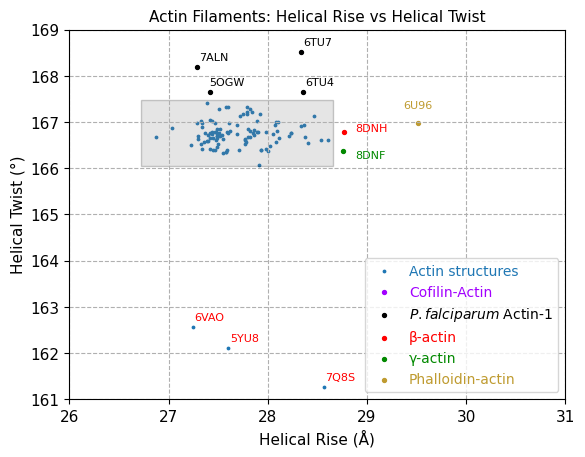

In [ ]:
#@title figure 1 rise vs twist
import matplotlib.pyplot as plt
import seaborn as sns  # For calculating IQR and identifying outliers
import pandas as pd
from matplotlib.patches import Rectangle

# Assuming 'df' is your DataFrame with 'x' and 'y' columns
# Replace 'x_column' and 'y_column' with the actual column names from your DataFrame
x_column = 'mean_rise'
y_column = 'mean_twist'
x_error = 'std_rise'
y_error = 'std_twist'

fig, ax = plt.subplots()
# Create a scatter plot
ax.scatter(df_rise_twist[x_column], df_rise_twist[y_column], label='Actin structures',s=3)

# Calculate interquartile range (IQR) for both columns
x_iqr = np.percentile(df_rise_twist[x_column], 75) - np.percentile(df_rise_twist[x_column], 25)
y_iqr = np.percentile(df_rise_twist[y_column], 75) - np.percentile(df_rise_twist[y_column], 25)

#outlie = iqr(data1, data2)
# Identify outliers using the IQR method
factor = 1.5

lower_bound_rise = df_rise_twist[x_column].quantile(0.25) - factor * x_iqr
upper_bound_rise = df_rise_twist[x_column].quantile(0.75) + factor * x_iqr

lower_bound_twist = df_rise_twist[y_column].quantile(0.25) - factor * y_iqr
upper_bound_twist = df_rise_twist[y_column].quantile(0.75) + factor * y_iqr

x_outliers = (df_rise_twist[x_column] < df_rise_twist[x_column].quantile(0.25) - factor * x_iqr) | (df_rise_twist[x_column] > df_rise_twist[x_column].quantile(0.75) + factor * x_iqr)
y_outliers = (df_rise_twist[y_column] < df_rise_twist[y_column].quantile(0.25) - factor * y_iqr) | (df_rise_twist[y_column] > df_rise_twist[y_column].quantile(0.75) + factor * y_iqr)

x_inliers = (df_rise_twist[x_column] > df_rise_twist[x_column].quantile(0.25) - factor * x_iqr) | (df_rise_twist[x_column] < df_rise_twist[x_column].quantile(0.75) + factor * x_iqr)
y_inliers = (df_rise_twist[y_column] > df_rise_twist[y_column].quantile(0.25) - factor * y_iqr) | (df_rise_twist[y_column] < df_rise_twist[y_column].quantile(0.75) + factor * y_iqr)

cofilin_outliers = (df_rise_twist['prot'] == 'cofilin')

pf_outliers = (df_rise_twist['organism'].str.contains('plasmodium', case=False))

x_out_rise = (df_rise_twist[x_error]  > 0.5)
y_out_twist = (df_rise_twist[y_error] > 1)


# # Shade the interquartile range
width = upper_bound_rise - lower_bound_rise
height = upper_bound_twist - lower_bound_twist
rectangle = Rectangle((lower_bound_rise, lower_bound_twist), width, height, edgecolor='black', facecolor='gray', alpha=0.2)
ax.add_patch(rectangle)

text_x = lower_bound_rise + 0.4
text_y = lower_bound_twist - 0.5
# ax.text(text_x, text_y, 'Q ± 1.5×IQR', horizontalalignment='center')

for i in df_rise_twist[x_column][x_outliers].index:
    if i in ['6U96-1']:
      plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]),
                   textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='#bf9b30')
    elif i in ['8DNH-1']:
      plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]),
                   textcoords="offset points", xytext=(20,0), ha='center', fontsize=8, color='red')
    else:
      plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]),
                   textcoords="offset points", xytext=(20,-5), ha='center', fontsize=8, color='#028900')

for i in df_rise_twist[x_column][y_outliers].index:
  if i in df_rise_twist[x_column][cofilin_outliers].index:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]),
                 textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='#a200ff')
  elif i in df_rise_twist[x_column][pf_outliers].index:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]),
                 textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='#000000')
  else:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]),
                 textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='red')

plt.scatter(df_rise_twist[x_column][cofilin_outliers], df_rise_twist[y_column][cofilin_outliers],
            label='Cofilin-Actin',
            color='#a200ff',
            s=8,
            marker = 'o',
            edgecolors='#a200ff')

plt.scatter(df_rise_twist[x_column][y_outliers & pf_outliers], df_rise_twist[y_column][y_outliers & pf_outliers],
            label='$\mathit{P.}$$\mathit{falciparum}$ Actin-1',
            color='#000000',
            s=8,
            marker = 'o',
            edgecolors='#000000')

plt.scatter(df_rise_twist[x_column]['8DNH-1'], df_rise_twist[y_column]['8DNH-1'],
            label='β-actin',
            color='red',
            s=8,
            marker = 'o',
            edgecolors='red')

plt.scatter(df_rise_twist[x_column]['8DNF-1'], df_rise_twist[y_column]['8DNF-1'],
            label='γ-actin',
            color='#028900',
            s=8,
            marker = 'o',
            edgecolors='#028900')

plt.scatter(df_rise_twist[x_column]['6U96-1'], df_rise_twist[y_column]['6U96-1'],
            label='Phalloidin-actin',
            color='#bf9b30',
            s=8,
            marker = 'o',
            edgecolors='#bf9b30')

# Set labels and title
plt.xlabel('Helical Rise (Å)')
plt.ylabel('Helical Twist (°)')
plt.title('Actin Filaments: Helical Rise vs Helical Twist')

# Display legend
plt.legend(loc='best',labelcolor='linecolor', bbox_to_anchor=(1, 0.4))
plt.grid(True,linestyle='--')
plt.xlim(26, 31)
plt.ylim(161, 169)
# Show the plot

# Set the DPI (dots per inch) for high resolution
dpi = 300

plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=11)
plt.rc('legend', fontsize=10)
plt.rc('figure', titlesize=14)
# Save the plot as a high-resolution PNG
plt.savefig('rise_vs_twist_plot_with_outliers.png', dpi=dpi)
plt.show()

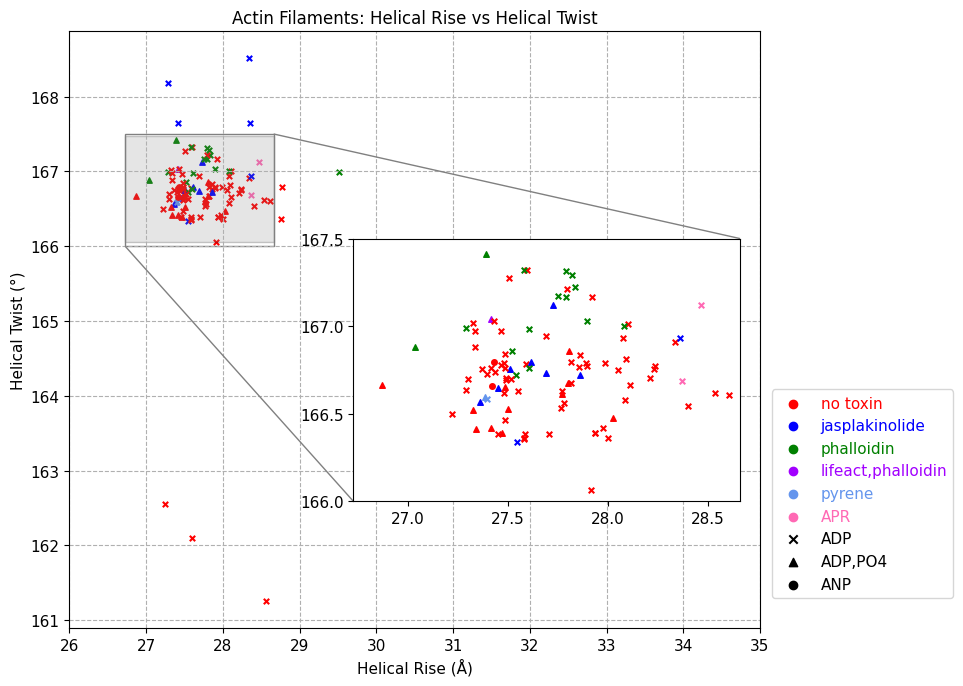

In [ ]:
#@title figure 1 nucleotide and toxin
import matplotlib.pyplot as plt
import seaborn as sns  # For calculating IQR and identifying outliers
import pandas as pd
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Assuming 'df' is your DataFrame with 'x' and 'y' columns
# Replace 'x_column' and 'y_column' with the actual column names from your DataFrame
x_column = 'mean_rise'
y_column = 'mean_twist'
x_error = 'std_rise'
y_error = 'std_twist'

shape_column = 'nucleotide'
color_column = 'toxin'

fig, ax = plt.subplots()
# Define color map (for customizing colors based on a column)
marker_map = {'ADP': 'x','ADP,PO4':'^','ANP':'o'}  # Customize colors as needed

# Define marker map (for customizing marker shapes based on a column)
color_map = {'no toxin': 'red', 'jasplakinolide': 'blue', 'phalloidin': 'green','lifeact,phalloidin':'#a200ff', 'pyrene':'cornflowerblue','APR':'hotpink'}  # Customize marker shapes as needed
# Create a scatter plot with customized color and marker shape
# Plot scatter points for color legend
for category, color in color_map.items():
    ax.scatter([], [], color=color, label=category)

# Plot scatter points for shape legend
for shape, marker in marker_map.items():
    ax.scatter([], [], color='black', marker=marker, label=shape)

# Iterate through each row in the DataFrame and plot each point individually
for index, row in df_rise_twist.iterrows():
    ax.scatter(row[x_column], row[y_column],
               marker=marker_map[row[shape_column]],
               color=color_map[row[color_column]],
              #  facecolors='none',
               s = 15)

# # Create a scatter plot
# ax.scatter(df_rise_twist[x_column], df_rise_twist[y_column], label='Actin structures',s=3)

# Calculate interquartile range (IQR) for both columns
x_iqr = np.percentile(df_rise_twist[x_column], 75) - np.percentile(df_rise_twist[x_column], 25)
y_iqr = np.percentile(df_rise_twist[y_column], 75) - np.percentile(df_rise_twist[y_column], 25)

#outlie = iqr(data1, data2)
# Identify outliers using the IQR method
factor = 1.5

lower_bound_rise = df_rise_twist[x_column].quantile(0.25) - factor * x_iqr
upper_bound_rise = df_rise_twist[x_column].quantile(0.75) + factor * x_iqr

lower_bound_twist = df_rise_twist[y_column].quantile(0.25) - factor * y_iqr
upper_bound_twist = df_rise_twist[y_column].quantile(0.75) + factor * y_iqr

x_outliers = (df_rise_twist[x_column] < df_rise_twist[x_column].quantile(0.25) - factor * x_iqr) | (df_rise_twist[x_column] > df_rise_twist[x_column].quantile(0.75) + factor * x_iqr)
y_outliers = (df_rise_twist[y_column] < df_rise_twist[y_column].quantile(0.25) - factor * y_iqr) | (df_rise_twist[y_column] > df_rise_twist[y_column].quantile(0.75) + factor * y_iqr)

x_out_rise = (df_rise_twist[x_error]  > 0.5)
y_out_twist = (df_rise_twist[y_error] > 1)

# # Shade the interquartile range
width = upper_bound_rise - lower_bound_rise
height = upper_bound_twist - lower_bound_twist
rectangle = Rectangle((lower_bound_rise, lower_bound_twist), width, height, edgecolor='black', facecolor='gray', alpha=0.2)
ax.add_patch(rectangle)
# Set labels and title
plt.xlabel('Helical Rise (Å)')
plt.ylabel('Helical Twist (°)')
plt.title('Actin Filaments: Helical Rise vs Helical Twist')
plt.legend(loc=1,labelcolor='linecolor', bbox_to_anchor=(1.28, 0.4),borderaxespad=0)
plt.grid(True,linestyle='--')
plt.xlim(26, 35)
dpi = 500
plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=12)
plt.rc('legend', fontsize=11)
plt.rc('figure', titlesize=18)

axins = inset_axes(ax, width="80%", height="55%",
                    bbox_to_anchor=(.40, .2, .7, .8),
                    bbox_transform=ax.transAxes,
                    loc=3)

# axins_ref = inset_axes(ax, width="80%", height="55%",
#                     bbox_to_anchor=(.40, .2, .7, .8),
#                     bbox_transform=ax.transAxes,
#                     loc=3)
# axins_ref.set_xticks([])
# axins_ref.set_yticks([])

for _, row in df_rise_twist.iterrows():
  if x_outliers[_] == False and y_outliers[_] == False:
    # if row['z_score_rise'] >= 3 or row['z_score_twist'] >= 3:
      axins.scatter(row[x_column], row[y_column], color=color_map[row[color_column]], marker=marker_map[row[shape_column]],
                  s =16)
      # plt.errorbar(row[x_column], row[y_column], xerr=row[x_error], yerr=row[y_error], fmt="o", color="r",capsize = 2, linewidth = 0.5, ms = 0.5,zorder=0)
      # plt.errorbar(row[x_column], row[y_column], xerr=row[x_error], yerr=row[y_error], fmt="o", color="r",capsize = 2, linewidth = 0.5, ms = 0.5, zorder=1)


axins.set_xlim([lower_bound_rise, upper_bound_rise])
axins.set_ylim([lower_bound_twist, upper_bound_twist])

# axins.set_xlim([26.75,28.5])
# axins.set_ylim([164,171])
axins.set_xticks([27, 27.5, 28, 28.5])
# axins.set_yticks([164,165,166,167,168,169,170])
axins.set_yticks([166,166.5, 167,167.5])

# axins_ref.set_xlim([lower_bound_rise, upper_bound_rise])
# axins_ref.set_ylim([lower_bound_twist, upper_bound_twist])

mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
fig.set_size_inches(10, 7)
fig.tight_layout()
# Save the plot as a high-resolution PNG
plt.savefig('rise_vs_twist_plot_with_nucleotide2.png', dpi=dpi)
plt.show()

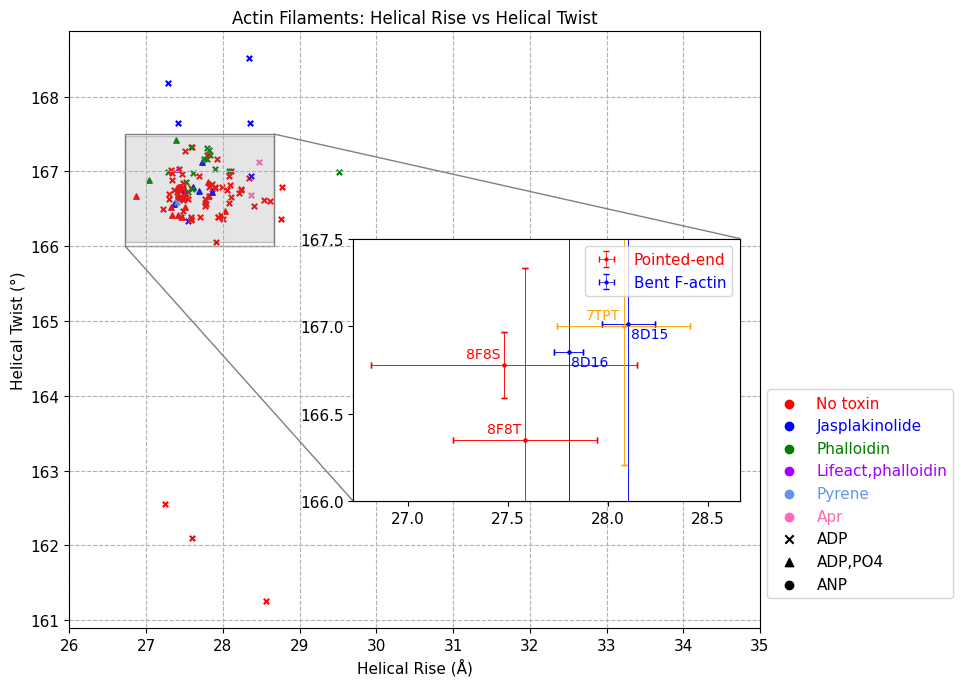

In [ ]:
#@title figure 1 nucleotide and toxin
import matplotlib.pyplot as plt
import seaborn as sns  # For calculating IQR and identifying outliers
import pandas as pd
from matplotlib.patches import Rectangle
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Assuming 'df' is your DataFrame with 'x' and 'y' columns
# Replace 'x_column' and 'y_column' with the actual column names from your DataFrame
x_column = 'mean_rise'
y_column = 'mean_twist'
x_error = 'std_rise'
y_error = 'std_twist'

shape_column = 'nucleotide'
color_column = 'toxin'

fig, ax = plt.subplots()
# Define color map (for customizing colors based on a column)
marker_map = {'ADP': 'x','ADP,PO4':'^','ANP':'o'}  # Customize colors as needed

# Define marker map (for customizing marker shapes based on a column)
color_map = {'no toxin': 'red', 'jasplakinolide': 'blue', 'phalloidin': 'green','lifeact,phalloidin':'#a200ff', 'pyrene':'cornflowerblue','APR':'hotpink'}  # Customize marker shapes as needed
# Create a scatter plot with customized color and marker shape
# Plot scatter points for color legend
for category, color in color_map.items():
    ax.scatter([], [], color=color, label=category.capitalize())

# Plot scatter points for shape legend
for shape, marker in marker_map.items():
    ax.scatter([], [], color='black', marker=marker, label=shape)

# Iterate through each row in the DataFrame and plot each point individually
for index, row in df_rise_twist.iterrows():
    ax.scatter(row[x_column], row[y_column],
               marker=marker_map[row[shape_column]],
               color=color_map[row[color_column]],
              #  facecolors='none',
               s = 15)

# # Create a scatter plot
# ax.scatter(df_rise_twist[x_column], df_rise_twist[y_column], label='Actin structures',s=3)

# Calculate interquartile range (IQR) for both columns
x_iqr = np.percentile(df_rise_twist[x_column], 75) - np.percentile(df_rise_twist[x_column], 25)
y_iqr = np.percentile(df_rise_twist[y_column], 75) - np.percentile(df_rise_twist[y_column], 25)

#outlie = iqr(data1, data2)
# Identify outliers using the IQR method
factor = 1.5

lower_bound_rise = df_rise_twist[x_column].quantile(0.25) - factor * x_iqr
upper_bound_rise = df_rise_twist[x_column].quantile(0.75) + factor * x_iqr

lower_bound_twist = df_rise_twist[y_column].quantile(0.25) - factor * y_iqr
upper_bound_twist = df_rise_twist[y_column].quantile(0.75) + factor * y_iqr

x_outliers = (df_rise_twist[x_column] < df_rise_twist[x_column].quantile(0.25) - factor * x_iqr) | (df_rise_twist[x_column] > df_rise_twist[x_column].quantile(0.75) + factor * x_iqr)
y_outliers = (df_rise_twist[y_column] < df_rise_twist[y_column].quantile(0.25) - factor * y_iqr) | (df_rise_twist[y_column] > df_rise_twist[y_column].quantile(0.75) + factor * y_iqr)

x_out_rise = (df_rise_twist[x_error]  > 0.5)
y_out_twist = (df_rise_twist[y_error] > 1)

# # Shade the interquartile range
width = upper_bound_rise - lower_bound_rise
height = upper_bound_twist - lower_bound_twist
rectangle = Rectangle((lower_bound_rise, lower_bound_twist), width, height, edgecolor='black', facecolor='gray', alpha=0.2)
ax.add_patch(rectangle)
# Set labels and title
plt.xlabel('Helical Rise (Å)')
plt.ylabel('Helical Twist (°)')
plt.title('Actin Filaments: Helical Rise vs Helical Twist')
plt.legend(loc=1,labelcolor='linecolor', bbox_to_anchor=(1.28, 0.4),borderaxespad=0)
plt.grid(True,linestyle='--')
plt.xlim(26, 35)
dpi = 500
plt.rc('font', size=11)          # controls default text sizes
plt.rc('axes', titlesize=12)
plt.rc('legend', fontsize=11)
plt.rc('figure', titlesize=18)

axins = inset_axes(ax, width="80%", height="55%",
                    bbox_to_anchor=(.40, .2, .7, .8),
                    bbox_transform=ax.transAxes,
                    loc=3)

axins_ref = inset_axes(ax, width="80%", height="55%",
                    bbox_to_anchor=(.40, .2, .7, .8),
                    bbox_transform=ax.transAxes,
                    loc=3)
axins_ref.set_xticks([])
axins_ref.set_yticks([])

my_label1 = 'Pointed-end'
my_label2 = 'Bent F-actin'
for _, row in df_rise_twist.iterrows():
  if x_outliers[_] == False and y_outliers[_] == False:
    if row['z_score_rise'] >= 3.5:

      axins.scatter(row[x_column], row[y_column], color=color_map[row[color_column]], marker=marker_map[row[shape_column]],
                  s =16)
      plt.errorbar(row[x_column], row[y_column], xerr=row[x_error], yerr=row[y_error], fmt="o", color="r",capsize = 2, linewidth = 0.5, ms = 2,zorder=0, label=my_label1)
      plt.errorbar(row[x_column], row[y_column], xerr=row[x_error], yerr=row[y_error], fmt="o", color="r",capsize = 2, linewidth = 0.5, ms = 2, zorder=1)
      plt.annotate(_[0:4], (row[x_column], row[y_column]),
                   textcoords="offset points", xytext=(-15,5), ha='center', fontsize=10, color='red')
      my_label1 = '_nolegend_'
    elif 3.5 >= row['z_score_rise'] >= 3.3:

      axins.scatter(row[x_column], row[y_column], color=color_map[row[color_column]], marker=marker_map[row[shape_column]],
                  s =16)
      plt.errorbar(row[x_column], row[y_column], xerr=row[x_error], yerr=row[y_error], fmt="o", color="orange",capsize = 2, linewidth = 0.5, ms = 2,zorder=0)
      plt.errorbar(row[x_column], row[y_column], xerr=row[x_error], yerr=row[y_error], fmt="o", color="orange",capsize = 2, linewidth = 0.5, ms = 2, zorder=1)
      plt.annotate(_[0:4], (row[x_column], row[y_column]),
                   textcoords="offset points", xytext=(-15,5), ha='center', fontsize=10, color='orange')
      my_label1 = '_nolegend_'
    elif row['z_score_twist'] >= 3:

      axins.scatter(row[x_column], row[y_column], color=color_map[row[color_column]], marker=marker_map[row[shape_column]],
                  s =16)
      plt.errorbar(row[x_column], row[y_column], xerr=row[x_error], yerr=row[y_error], fmt="o", color="b",capsize = 2, linewidth = 0.5, ms = 2,zorder=0, label = my_label2)
      plt.errorbar(row[x_column], row[y_column], xerr=row[x_error], yerr=row[y_error], fmt="o", color="b",capsize = 2, linewidth = 0.5, ms = 2, zorder=1)
      plt.annotate(_[0:4], (row[x_column], row[y_column]),
                   textcoords="offset points", xytext=(15,-10), ha='center', fontsize=10, color='blue')
      my_label2 = '_nolegend_'
plt.legend(loc='best',labelcolor='linecolor')
axins.set_xlim([lower_bound_rise, upper_bound_rise])
axins.set_ylim([lower_bound_twist, upper_bound_twist])

# axins.set_xlim([26.75,28.5])
# axins.set_ylim([164,171])
axins.set_xticks([27, 27.5, 28, 28.5])
# axins.set_yticks([164,165,166,167,168,169,170])
axins.set_yticks([166,166.5, 167,167.5])

axins_ref.set_xlim([lower_bound_rise, upper_bound_rise])
axins_ref.set_ylim([lower_bound_twist, upper_bound_twist])

mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")
fig.set_size_inches(10, 7)
fig.tight_layout()
# Save the plot as a high-resolution PNG
plt.savefig('rise_vs_twist_plot_with_nucleotide2.png', dpi=dpi)
plt.show()

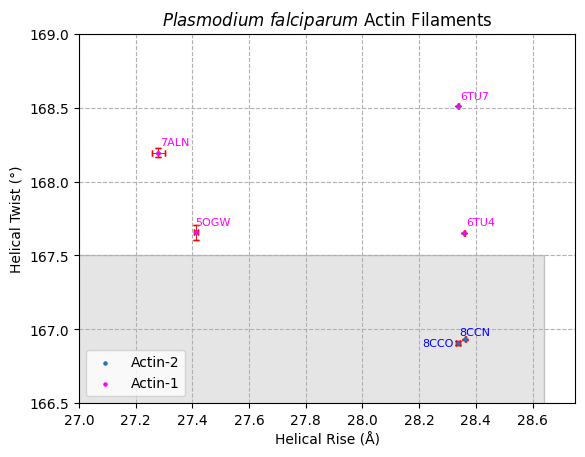

In [ ]:
#@title plasmodium
import matplotlib.pyplot as plt
import seaborn as sns  # For calculating IQR and identifying outliers
import pandas as pd
from matplotlib.patches import Rectangle

# Assuming 'df' is your DataFrame with 'x' and 'y' columns
# Replace 'x_column' and 'y_column' with the actual column names from your DataFrame
x_column = 'mean_rise'
y_column = 'mean_twist'
x_error = 'std_rise'
y_error = 'std_twist'
org_nism = 'Plasmodium'

df_rise_twist_org_dict = {}
for index, row in df_rise_twist.iterrows():
  if org_nism in row['organism']:
    df_rise_twist_org_dict[index] = row.to_dict()

df_rise_twist_org = pd.DataFrame.from_dict(df_rise_twist_org_dict, orient = 'index')
fig, ax = plt.subplots()
# Create a scatter plot
ax.scatter(df_rise_twist_org[x_column], df_rise_twist_org[y_column], label='Actin-2',s=5,zorder=2)

# plt.errorbar(df_rise_twist[x_column], df_rise_twist[y_column], markersize = 1, xerr=df_rise_twist[x_error], yerr=df_rise_twist[y_error], fmt="o", color="b")
# plt.errorbar(df_rise_twist[x_column], df_rise_twist[y_column], markersize = 1, xerr=df_rise_twist[x_error], yerr=df_rise_twist[y_error], fmt="o", color="b")
# Calculate interquartile range (IQR) for both columns
x_iqr = np.percentile(df_rise_twist[x_column], 75) - np.percentile(df_rise_twist[x_column], 25)
y_iqr = np.percentile(df_rise_twist[y_column], 75) - np.percentile(df_rise_twist[y_column], 25)

#outlie = iqr(data1, data2)
# Identify outliers using the IQR method
factor = 1.5

lower_bound_rise = df_rise_twist[x_column].quantile(0.25) - factor * x_iqr
upper_bound_rise = df_rise_twist[x_column].quantile(0.75) + factor * x_iqr

lower_bound_twist = df_rise_twist[y_column].quantile(0.25) - factor * y_iqr
upper_bound_twist = df_rise_twist[y_column].quantile(0.75) + factor * y_iqr

x_outliers = (df_rise_twist[x_column] < df_rise_twist[x_column].quantile(0.25) - factor * x_iqr) | (df_rise_twist[x_column] > df_rise_twist[x_column].quantile(0.75) + factor * x_iqr)
y_outliers = (df_rise_twist[y_column] < df_rise_twist[y_column].quantile(0.25) - factor * y_iqr) | (df_rise_twist[y_column] > df_rise_twist[y_column].quantile(0.75) + factor * y_iqr)
x_out_rise = (df_rise_twist_org[x_error]  > 0.5)
y_out_twist = (df_rise_twist_org[y_error] > 1)


# # Shade the interquartile range
# plt.axvspan(lower_bound_rise, upper_bound_rise, alpha=0.2, color='gray', label='IQR (x)')
# plt.axhspan(lower_bound_twist, upper_bound_twist, alpha=0.2, color='gray', label='IQR (y)')
width = upper_bound_rise - lower_bound_rise
height = upper_bound_twist - lower_bound_twist
rectangle = Rectangle((lower_bound_rise, lower_bound_twist), width, height, edgecolor='black', facecolor='gray', alpha=0.2)
ax.add_patch(rectangle)
text_x = lower_bound_rise + 0.4
text_y = lower_bound_twist - 1
# ax.text(text_x, text_y, 'Q ± 1.5×IQR', horizontalalignment='center')

# for i in df_rise_twist_org[x_column][x_outliers].index:
# #   if i in ['6U96-1']:
# #     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')
# #   elif i in ['8DNH-1']:
# #     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(20,0), ha='center', fontsize=8, color='red')
# #   else:
# #     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(20,-5), ha='center', fontsize=8, color='red')
#       plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(20,-5), ha='center', fontsize=8, color='#FF00FF')

# for i in df_rise_twist_org[x_column][y_outliers].index:
#     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='#FF00FF')

for i in df_rise_twist_org[x_column].index:
  if x_outliers[i] == True or y_outliers[i] == True:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='#FF00FF')
  elif i in ['8CCN-1']:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='blue')
  else:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(-20,-5), ha='center', fontsize=8, color='blue')
# Color outliers differently
plt.scatter(df_rise_twist_org[x_column][x_outliers], df_rise_twist_org[y_column][x_outliers], color='#FF00FF', label='Actin-1',s=5,zorder=3)
plt.scatter(df_rise_twist_org[x_column][y_outliers], df_rise_twist_org[y_column][y_outliers], color='#FF00FF',s=5,zorder=4)

plt.errorbar(df_rise_twist_org[x_column], df_rise_twist_org[y_column], xerr=df_rise_twist_org[x_error], yerr=df_rise_twist_org[y_error], fmt="o", color="r",capsize = 2, linewidth = 0.5, ms = 0.5,zorder=0)
plt.errorbar(df_rise_twist_org[x_column], df_rise_twist_org[y_column], xerr=df_rise_twist_org[x_error], yerr=df_rise_twist_org[y_error], fmt="o", color="r",capsize = 2, linewidth = 0.5, ms = 0.5, zorder=1)

# plt.errorbar(df_rise_twist[x_column][x_out_rise], df_rise_twist[y_column][x_out_rise], markersize = 1, xerr=df_rise_twist[x_error][x_out_rise], yerr=df_rise_twist[y_error][x_out_rise], fmt="o", color="r")
# plt.errorbar(df_rise_twist[x_column][y_out_twist], df_rise_twist[y_column][y_out_twist], markersize = 1, xerr=df_rise_twist[x_error][y_out_twist], yerr=df_rise_twist[y_error][y_out_twist], fmt="o", color="r")
# for i in df_rise_twist[x_column][y_out_twist].index:
#     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='green')
# for i in df_rise_twist[x_column][x_out_rise].index:
#     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='blue')


# Set labels and title
plt.xlabel('Helical Rise (Å)')
plt.ylabel('Helical Twist (°)')
plt.title('$\mathit{Plasmodium}$ $\mathit{ falciparum}$ Actin Filaments')

# Display legend
plt.legend(loc=3)
plt.grid(True,linestyle='--')
plt.xlim(27, 28.75)
plt.ylim(166.5, 169)
# Show the plot

# Set the DPI (dots per inch) for high resolution
dpi = 300

# Save the plot as a high-resolution PNG
plt.savefig('rise_vs_twist_plot_with_outliers.png', dpi=dpi)
plt.show()

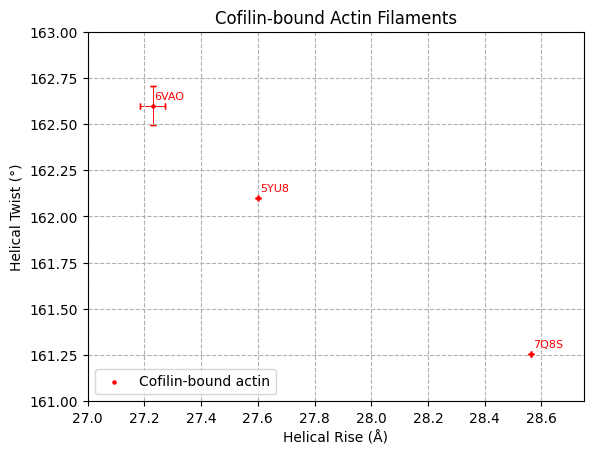

In [ ]:
#@title cofilin
import matplotlib.pyplot as plt
import seaborn as sns  # For calculating IQR and identifying outliers
import pandas as pd
from matplotlib.patches import Rectangle

# Assuming 'df' is your DataFrame with 'x' and 'y' columns
# Replace 'x_column' and 'y_column' with the actual column names from your DataFrame
x_column = 'mean_rise'
y_column = 'mean_twist'
x_error = 'std_rise'
y_error = 'std_twist'
org_nism = 'cofilin'

df_rise_twist_org_dict = {}
for index, row in df_rise_twist.iterrows():
  if org_nism in row['prot']:
    df_rise_twist_org_dict[index] = row.to_dict()

df_rise_twist_org = pd.DataFrame.from_dict(df_rise_twist_org_dict, orient = 'index')
fig, ax = plt.subplots()
# Create a scatter plot
ax.scatter(df_rise_twist_org[x_column], df_rise_twist_org[y_column], label='Cofilin-bound actin',s=5,zorder=2, color = 'red')

# plt.errorbar(df_rise_twist[x_column], df_rise_twist[y_column], markersize = 1, xerr=df_rise_twist[x_error], yerr=df_rise_twist[y_error], fmt="o", color="b")
# plt.errorbar(df_rise_twist[x_column], df_rise_twist[y_column], markersize = 1, xerr=df_rise_twist[x_error], yerr=df_rise_twist[y_error], fmt="o", color="b")
# Calculate interquartile range (IQR) for both columns
x_iqr = np.percentile(df_rise_twist[x_column], 75) - np.percentile(df_rise_twist[x_column], 25)
y_iqr = np.percentile(df_rise_twist[y_column], 75) - np.percentile(df_rise_twist[y_column], 25)

#outlie = iqr(data1, data2)
# Identify outliers using the IQR method
factor = 1.5

lower_bound_rise = df_rise_twist[x_column].quantile(0.25) - factor * x_iqr
upper_bound_rise = df_rise_twist[x_column].quantile(0.75) + factor * x_iqr

lower_bound_twist = df_rise_twist[y_column].quantile(0.25) - factor * y_iqr
upper_bound_twist = df_rise_twist[y_column].quantile(0.75) + factor * y_iqr

x_outliers = (df_rise_twist[x_column] < df_rise_twist[x_column].quantile(0.25) - factor * x_iqr) | (df_rise_twist[x_column] > df_rise_twist[x_column].quantile(0.75) + factor * x_iqr)
y_outliers = (df_rise_twist[y_column] < df_rise_twist[y_column].quantile(0.25) - factor * y_iqr) | (df_rise_twist[y_column] > df_rise_twist[y_column].quantile(0.75) + factor * y_iqr)
x_out_rise = (df_rise_twist_org[x_error]  > 0.5)
y_out_twist = (df_rise_twist_org[y_error] > 1)


# # Shade the interquartile range
# plt.axvspan(lower_bound_rise, upper_bound_rise, alpha=0.2, color='gray', label='IQR (x)')
# plt.axhspan(lower_bound_twist, upper_bound_twist, alpha=0.2, color='gray', label='IQR (y)')
width = upper_bound_rise - lower_bound_rise
height = upper_bound_twist - lower_bound_twist
rectangle = Rectangle((lower_bound_rise, lower_bound_twist), width, height, edgecolor='black', facecolor='gray', alpha=0.2)
ax.add_patch(rectangle)
text_x = lower_bound_rise + 0.4
text_y = lower_bound_twist - 1
# ax.text(text_x, text_y, 'Q ± 1.5×IQR', horizontalalignment='center')

# for i in df_rise_twist_org[x_column][x_outliers].index:
# #   if i in ['6U96-1']:
# #     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')
# #   elif i in ['8DNH-1']:
# #     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(20,0), ha='center', fontsize=8, color='red')
# #   else:
# #     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(20,-5), ha='center', fontsize=8, color='red')
#       plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(20,-5), ha='center', fontsize=8, color='#FF00FF')

# for i in df_rise_twist_org[x_column][y_outliers].index:
#     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='#FF00FF')

for i in df_rise_twist_org[x_column].index:
  if x_outliers[i] == True or y_outliers[i] == True:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='red')
  elif i in ['8CCN-1']:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='blue')
  else:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(-20,-5), ha='center', fontsize=8, color='blue')
# Color outliers differently
# plt.scatter(df_rise_twist_org[x_column][x_outliers], df_rise_twist_org[y_column][x_outliers], color='#FF00FF', label='Actin-1',s=5,zorder=3)
# plt.scatter(df_rise_twist_org[x_column][y_outliers], df_rise_twist_org[y_column][y_outliers], color='#FF00FF',s=5,zorder=4)

plt.errorbar(df_rise_twist_org[x_column], df_rise_twist_org[y_column], xerr=df_rise_twist_org[x_error], yerr=df_rise_twist_org[y_error], fmt="o", color="r",capsize = 2, linewidth = 0.5, ms = 0.5,zorder=0)
plt.errorbar(df_rise_twist_org[x_column], df_rise_twist_org[y_column], xerr=df_rise_twist_org[x_error], yerr=df_rise_twist_org[y_error], fmt="o", color="r",capsize = 2, linewidth = 0.5, ms = 0.5, zorder=1)

# plt.errorbar(df_rise_twist[x_column][x_out_rise], df_rise_twist[y_column][x_out_rise], markersize = 1, xerr=df_rise_twist[x_error][x_out_rise], yerr=df_rise_twist[y_error][x_out_rise], fmt="o", color="r")
# plt.errorbar(df_rise_twist[x_column][y_out_twist], df_rise_twist[y_column][y_out_twist], markersize = 1, xerr=df_rise_twist[x_error][y_out_twist], yerr=df_rise_twist[y_error][y_out_twist], fmt="o", color="r")
# for i in df_rise_twist[x_column][y_out_twist].index:
#     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='green')
# for i in df_rise_twist[x_column][x_out_rise].index:
#     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='blue')


# Set labels and title
plt.xlabel('Helical Rise (Å)')
plt.ylabel('Helical Twist (°)')
plt.title('Cofilin-bound Actin Filaments')

# Display legend
plt.legend(loc=3)
plt.grid(True,linestyle='--')
plt.xlim(27, 28.75)
plt.ylim(161, 163)
# Show the plot

# Set the DPI (dots per inch) for high resolution
dpi = 300

# Save the plot as a high-resolution PNG
plt.savefig('rise_vs_twist_plot_with_outliers.png', dpi=dpi)
plt.show()

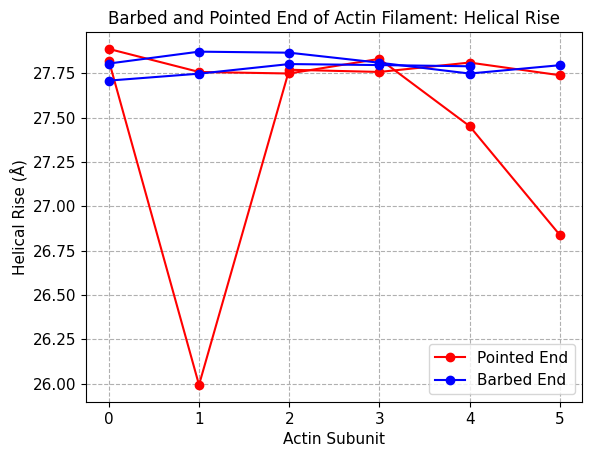

In [ ]:
#@title pointed_barbed_end

import matplotlib.pyplot as plt

sub_rise_dict_p = {}
sub_rise_dict_b = {}
sub_rise_dict_c = {}
for k, v in all_rise_dict.items():
  for index, row in df_rise_twist.iterrows():
    if k[0:4] in index and row['act_end'] == "pointed_end" and '8IB2' not in index:
      sub_rise_dict_p[k] = v
    elif k[0:4] in index and row['act_end'] == "barbed_end" and index not in ['7PDZ-1','8OI6-1']:
      sub_rise_dict_b[k] = v
    elif k[0:4] in index and index in ['8F8P-1']:
      sub_rise_dict_c[k] = v
# Sample dictionary with keys and corresponding lists of values
# data = {
#     'A': [1, 2, 3, 4, 5],
#     'B': [5, 4, 3, 2, 1],
#     'C': [2, 3, 2, 3, 2]
# }

# Plot each key-value pair
for key, values in sub_rise_dict_p.items():
  if key == '8F8S-1':
    plt.plot(values, label='Pointed End', marker = 'o', color = 'red')
  else:
    plt.plot(values, label='_Pointed End', marker = 'o', color = 'red')

for key, values in sub_rise_dict_b.items():
  if key == "8F8R-1":
    plt.plot(values, label='Barbed End', marker = 'o', color = 'blue')
  else:
    plt.plot(values, label='_Barbed End', marker = 'o', color = 'blue')

# for key, values in sub_rise_dict_c.items():
#   if key == "8F8P-1":
#     plt.plot(values, label='ADP-F-actin', marker = 'o', color = 'green')
# for key, values in sub_rise_dict_c.items():
#   if key == "8F8P-1":
#     plt.plot(values, label='Barbed End', marker = 'o', color = 'green')
#   else:
#     plt.plot(values, label='_Barbed End', marker = 'o', color = 'green')

# Add labels and legend
plt.xlabel('Actin Subunit')
plt.ylabel('Helical Rise (Å)')
plt.title('Barbed and Pointed End of Actin Filament: Helical Rise')
plt.legend()
# Set the DPI (dots per inch) for high resolution
dpi = 300
plt.grid(True,linestyle='--')
# Save the plot as a high-resolution PNG
plt.savefig('rise_vs_twist_plot_with_outliers.png', dpi=dpi)
plt.show()


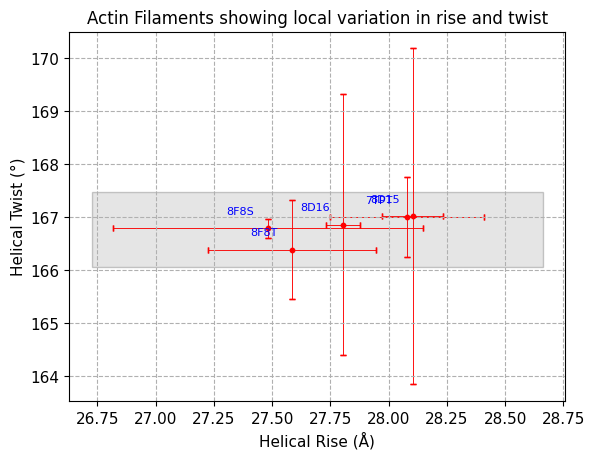

In [ ]:
#@title zscore local variation
import matplotlib.pyplot as plt
import seaborn as sns  # For calculating IQR and identifying outliers
import pandas as pd
from matplotlib.patches import Rectangle

# Assuming 'df' is your DataFrame with 'x' and 'y' columns
# Replace 'x_column' and 'y_column' with the actual column names from your DataFrame
x_column = 'mean_rise'
y_column = 'mean_twist'
x_error = 'std_rise'
y_error = 'std_twist'

df_rise_twist_org_dict = {}
for index, row in df_rise_twist.iterrows():
  if row['z_score_rise'] > 3 or row['z_score_twist'] > 3:
    df_rise_twist_org_dict[index] = row.to_dict()

df_rise_twist_org = pd.DataFrame.from_dict(df_rise_twist_org_dict, orient = 'index')
fig, ax = plt.subplots()
# Create a scatter plot
ax.scatter(df_rise_twist_org[x_column], df_rise_twist_org[y_column], #label='actin',
           s=10,zorder=2, color = 'red')

# plt.errorbar(df_rise_twist[x_column], df_rise_twist[y_column], markersize = 1, xerr=df_rise_twist[x_error], yerr=df_rise_twist[y_error], fmt="o", color="b")
# plt.errorbar(df_rise_twist[x_column], df_rise_twist[y_column], markersize = 1, xerr=df_rise_twist[x_error], yerr=df_rise_twist[y_error], fmt="o", color="b")
# Calculate interquartile range (IQR) for both columns
x_iqr = np.percentile(df_rise_twist[x_column], 75) - np.percentile(df_rise_twist[x_column], 25)
y_iqr = np.percentile(df_rise_twist[y_column], 75) - np.percentile(df_rise_twist[y_column], 25)

#outlie = iqr(data1, data2)
# Identify outliers using the IQR method
factor = 1.5

lower_bound_rise = df_rise_twist[x_column].quantile(0.25) - factor * x_iqr
upper_bound_rise = df_rise_twist[x_column].quantile(0.75) + factor * x_iqr

lower_bound_twist = df_rise_twist[y_column].quantile(0.25) - factor * y_iqr
upper_bound_twist = df_rise_twist[y_column].quantile(0.75) + factor * y_iqr

x_outliers = (df_rise_twist[x_column] < df_rise_twist[x_column].quantile(0.25) - factor * x_iqr) | (df_rise_twist[x_column] > df_rise_twist[x_column].quantile(0.75) + factor * x_iqr)
y_outliers = (df_rise_twist[y_column] < df_rise_twist[y_column].quantile(0.25) - factor * y_iqr) | (df_rise_twist[y_column] > df_rise_twist[y_column].quantile(0.75) + factor * y_iqr)
x_out_rise = (df_rise_twist_org[x_error]  > 0.5)
y_out_twist = (df_rise_twist_org[y_error] > 1)


# # Shade the interquartile range
# plt.axvspan(lower_bound_rise, upper_bound_rise, alpha=0.2, color='gray', label='IQR (x)')
# plt.axhspan(lower_bound_twist, upper_bound_twist, alpha=0.2, color='gray', label='IQR (y)')
width = upper_bound_rise - lower_bound_rise
height = upper_bound_twist - lower_bound_twist
rectangle = Rectangle((lower_bound_rise, lower_bound_twist), width, height, edgecolor='black', facecolor='gray', alpha=0.2)
ax.add_patch(rectangle)
text_x = lower_bound_rise + 0.4
text_y = lower_bound_twist - 1
# ax.text(text_x, text_y, 'Q ± 1.5×IQR', horizontalalignment='center')

# for i in df_rise_twist_org[x_column][x_outliers].index:
# #   if i in ['6U96-1']:
# #     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=8, color='red')
# #   elif i in ['8DNH-1']:
# #     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(20,0), ha='center', fontsize=8, color='red')
# #   else:
# #     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(20,-5), ha='center', fontsize=8, color='red')
#       plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(20,-5), ha='center', fontsize=8, color='#FF00FF')

# for i in df_rise_twist_org[x_column][y_outliers].index:
#     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='#FF00FF')





for i in df_rise_twist_org[x_column].index:
  if x_outliers[i] == True or y_outliers[i] == True:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,10), ha='center', fontsize=8, color='red')
  elif i in ['8CCN-1']:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,10), ha='center', fontsize=8, color='blue')
  else:
    plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(-20,10), ha='center', fontsize=8, color='blue')





# Color outliers differently
# plt.scatter(df_rise_twist_org[x_column][x_outliers], df_rise_twist_org[y_column][x_outliers], color='#FF00FF', label='Actin-1',s=5,zorder=3)
# plt.scatter(df_rise_twist_org[x_column][y_outliers], df_rise_twist_org[y_column][y_outliers], color='#FF00FF',s=5,zorder=4)

plt.errorbar(df_rise_twist_org[x_column], df_rise_twist_org[y_column], xerr=df_rise_twist_org[x_error], yerr=df_rise_twist_org[y_error], fmt="o", color="r",capsize = 2, linewidth = 0.5, ms = 0.5,zorder=0)
plt.errorbar(df_rise_twist_org[x_column], df_rise_twist_org[y_column], xerr=df_rise_twist_org[x_error], yerr=df_rise_twist_org[y_error], fmt="o", color="r",capsize = 2, linewidth = 0.5, ms = 0.5, zorder=1)

# plt.errorbar(df_rise_twist[x_column][x_out_rise], df_rise_twist[y_column][x_out_rise], markersize = 1, xerr=df_rise_twist[x_error][x_out_rise], yerr=df_rise_twist[y_error][x_out_rise], fmt="o", color="r")
# plt.errorbar(df_rise_twist[x_column][y_out_twist], df_rise_twist[y_column][y_out_twist], markersize = 1, xerr=df_rise_twist[x_error][y_out_twist], yerr=df_rise_twist[y_error][y_out_twist], fmt="o", color="r")
# for i in df_rise_twist[x_column][y_out_twist].index:
#     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='green')
# for i in df_rise_twist[x_column][x_out_rise].index:
#     plt.annotate(i[0:4], (df_rise_twist[x_column][i], df_rise_twist[y_column][i]), textcoords="offset points", xytext=(12,5), ha='center', fontsize=8, color='blue')

# Set labels and title
plt.xlabel('Helical Rise (Å)')
plt.ylabel('Helical Twist (°)')
plt.title('Actin Filaments showing local variation in rise and twist')

# Display legend
# plt.legend(loc=3)
plt.grid(True,linestyle='--')
# plt.xlim(27, 28.75)
# plt.ylim(161, 163)
# Show the plot

# Set the DPI (dots per inch) for high resolution
dpi = 300

# Save the plot as a high-resolution PNG
# plt.savefig('rise_vs_twist_plot_with_outliers.png', dpi=dpi)
plt.show()

## Plots interactive

In [ ]:
#@title subplota
import plotly.express as px
import pandas as pd
import random

col_col = 'prot' #@param ["organism","toxin","nucleotide","prot",'act_type','act_end']
random.seed(99)
def generate_random_colors(n):
  """Generates n random colors.

  Args:
    n: The number of colors to generate.

  Returns:
    A list of n random colors.
  """
# rgb(255, 0, 0)
  colors = []
  for i in range(n):
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    colors.append('rgb'+str((r, g, b)))
  return colors

col_map_ = generate_random_colors(len(df_rise_twist.prot.unique()))
# Create a scatter plot with colors based on 'color_column' using Plotly Express
fig = px.scatter(df_rise_twist, x='mean_rise', y='mean_twist', color= col_col,
                 color_discrete_sequence= col_map_,#px.colors.sequential.Plasma_r,
                 title='Actin Filaments: Helical Twist vs Helical Rise',
                 hover_name = df_rise_twist.index
                 )
fig.add_hrect(y0=lower_bound_twist, y1=upper_bound_twist)
fig.add_vrect(x0=lower_bound_rise, x1=upper_bound_rise)
# Show the plot

fig.update_xaxes(title_text="Mean Helical Rise")
fig.update_xaxes(gridcolor='grey', griddash='dash',
                 showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_yaxes(title_text="Mean Helical Twist")
fig.update_yaxes(gridcolor='grey', griddash='dash',
                 showline=True, linewidth=2, linecolor='black', mirror=True)
fig.update_layout({'plot_bgcolor':'rgba(0,0,0,0)'})
fig.update_layout(
    title={
        'text': "Actin Filaments with Non-actin Interactors: Helical Twist vs Rise",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.update_layout(
    legend_title="Actin-interactors",
    font=dict(
        family="Arial",
        size=16,
        color="black"
    ),
    width = 1000,
    height = 700,
    legend_itemsizing='constant'
)


In [ ]:
#@title org plots
import plotly.express as px
import pandas as pd
import random

org_nism = 'Homo sapiens' #@param ['Oryctolagus cuniculus', 'Sus scrofa','Plasmodium falciparum','Gallus gallus','Homo sapiens']
col_col = 'prot' #@param ["organism","toxin","nucleotide","prot"]
random.seed(99)
def generate_random_colors(n):
  """Generates n random colors.

  Args:
    n: The number of colors to generate.

  Returns:
    A list of n random colors.
  """
# rgb(255, 0, 0)
  colors = []
  for i in range(n):
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    colors.append('rgb'+str((r, g, b)))
  return colors

col_map_ = generate_random_colors(len(df_rise_twist.prot.unique()))
# Create a scatter plot with colors based on 'color_column' using Plotly Express
fig = px.scatter(df_rise_twist[df_rise_twist['organism'] == org_nism], x='mean_rise', y='mean_twist', color= col_col,
                 color_discrete_sequence= col_map_,#px.colors.sequential.Plasma_r,
                 title='Actin Filaments: Helical Twist vs Helical Rise',
                 hover_name = df_rise_twist[df_rise_twist['organism'] == org_nism].index
                 )
fig.add_hrect(y0=lower_bound_twist, y1=upper_bound_twist)
fig.add_vrect(x0=lower_bound_rise, x1=upper_bound_rise)
# Show the plot
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd
import random

random.seed(99)
def generate_random_colors(n):
  """Generates n random colors.

  Args:
    n: The number of colors to generate.

  Returns:
    A list of n random colors.
  """
# rgb(255, 0, 0)
  colors = []
  for i in range(n):
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    colors.append('rgb'+str((r, g, b)))
  return colors

col_map_ = generate_random_colors(len(df_rise_twist.prot.unique()))
# Create a scatter plot with colors based on 'color_column' using Plotly Express
fig = px.scatter(df_rise_twist[df_rise_twist['organism'] == 'Oryctolagus cuniculus'], y='mean_rise', x='mean_twist', color='prot',
                 color_discrete_sequence= col_map_,#px.colors.sequential.Plasma_r,
                 title='Actin Filaments: Helical Rise vs Helical Twist',
                 hover_name = df_rise_twist[df_rise_twist['organism'] == 'Oryctolagus cuniculus'].index
                 )
fig.add_vrect(x0=lower_bound_twist, x1=upper_bound_twist)
fig.add_hrect(y0=lower_bound_rise, y1=upper_bound_rise)
# Show the plot
fig.show()

In [ ]:
fig.write_html("twist_vs_rise_px_res_4_organism.html")